# INITIALIZING

In [ ]:
import os
import csv
import copy
import math
import random
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize, scale
from torch.optim import lr_scheduler
from tqdm import tqdm
import torch.nn.utils.prune as prune

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

# Random seed setup
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Hyperparameters
n_split = 10
num_epochs = 60
weight_decay = 0
hidden_weights_pruning = True
hidden_weights_pruning_ratio = 0.9
early_stop = 50
batch_size = 45
lr = 0.001
embedding_size = 200
embedding_size_last = 320
num_blocks = 4
n_head = 4
using_cancer_type = True
scale_y = True
using_tf_gene_matrix = True
trim_ratio = 0.6
top_k = math.floor(embedding_size * trim_ratio)
top_k_last_layer = math.floor(embedding_size_last * trim_ratio)
embed_pretrain_gene2vec = True
permutation_sga_tissue = False


Using device: cuda
NVIDIA GeForce RTX 4050 Laptop GPU


# Setting up Data

In [ ]:
# Load required datasets
tf_gene_df = pd.read_csv("Data/CITRUS_tf_gene.csv", index_col=0) if using_tf_gene_matrix else None
tcga_sga_df = pd.read_csv("Data/TCGA_sga_data.csv", index_col=0)
tcga_RNAseq_df = pd.read_csv("Data/TCGA_RNAseq_data.csv", index_col=0)
tcga_can_df = pd.read_csv("Data/TCGA_xena_map_cancertype.csv", index_col=0)
gdsc_sga_df = pd.read_csv("Data/GDSC_sga_data.csv", index_col=0)
gdsc_RNAseq_df = pd.read_csv("Data/GDSC_RNAseq_data.csv", index_col=0)
gdsc_can_df = pd.read_csv("Data/GDSC_cancer_type.csv", index_col=0)

# Data cleaning and alignment
tcga_RNAseq_df[tcga_RNAseq_df < 0] = 0
gdsc_RNAseq_df[gdsc_RNAseq_df < 0] = 0
tcga_RNAseq_df = tcga_RNAseq_df.loc[tcga_sga_df.index, :]
tcga_can_df = tcga_can_df.loc[tcga_sga_df.index, ["cancer_type"]]
gdsc_RNAseq_df = gdsc_RNAseq_df.loc[gdsc_sga_df.index, :]
gdsc_can_df = gdsc_can_df.loc[gdsc_sga_df.index, :]


# Combine TCGA and GDSC datasets
sga_df = pd.concat([tcga_sga_df, gdsc_sga_df])
deg_df = pd.concat([tcga_RNAseq_df, gdsc_RNAseq_df])
can_df = pd.concat([tcga_can_df, gdsc_can_df])

gene_exprs_list = pd.read_csv("Data/exprs_gene_list_GDSC_yifan_mike.txt", header=None)
gene_sga_list = pd.read_csv("Data/TCI_fondation1_driver_dataset_combine_gene_list.txt", header=None)

common_gene_sga = [gene for gene in sga_df.columns if gene in gene_sga_list.iloc[:, 0].tolist()]
common_gene_exprs = [gene for gene in deg_df.columns if gene in gene_exprs_list.iloc[:, 0].tolist()]
if using_tf_gene_matrix:
    tf_gene_df[tf_gene_df>0]=1
    tf_gene_gene_list = tf_gene_df.columns
    common_gene_exprs = [gene for gene in common_gene_exprs if gene in tf_gene_df.columns]
    tf_gene_df = tf_gene_df.loc[:, common_gene_exprs]

sga_df = sga_df.loc[:, common_gene_sga]
deg_df = deg_df.loc[:, common_gene_exprs]

def map_cancer_type_to_id(df):
    mapping = {name: idx for idx, name in enumerate(df["cancer_type"].unique())}
    df["cancer_type"] = df["cancer_type"].map(mapping)
    return df, len(mapping)

can_df, can_size = map_cancer_type_to_id(can_df)

def sga_features_to_indices(sga_df):
    sga_feats = sga_df.to_numpy()   
    non_zero_idx = np.where(sga_feats != 0)
    sga_feats[non_zero_idx[0], non_zero_idx[1]] = np.array(non_zero_idx[1]) + 1  
    sga_df = pd.DataFrame(sga_feats, index=sga_df.index, columns=sga_df.columns) 
    return sga_df
sga_df = sga_features_to_indices(sga_df)
print(sga_df,deg_df)


                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

                  ALK  ...   AR   EPHA6  LETM2  KIT

# MODEL

In [ ]:
import torch
import torch.nn as nn
from gensim.models import Word2Vec
import pandas as pd
import numpy as np


class SGASelfAttn(nn.Module):
    """
    Implements a multi-head self-attention mechanism for SGA.
    Produces an embedding of dimension `embedding_dim` for a vector of SGA statuses.
    """

    def __init__(self, sga_gene_list, sga_size, embedding_dim, n_head, using_gene2vec_pretrain):
        super(SGASelfAttn, self).__init__()
        self.sga_gene_list = sga_gene_list
        self.sga_size = sga_size
        self.embedding_dim = embedding_dim
        self.n_head = n_head
        self.using_gene2vec_pretrain = using_gene2vec_pretrain

        # Initialize SGA embeddings
        if using_gene2vec_pretrain:
            gene2vec_model = Word2Vec.load(f"Processed Data/gene2vec/word2vec.model_{embedding_dim}")
            w2v_dict = {item: gene2vec_model.wv[item] for item in gene2vec_model.wv.key_to_index}
            gene2vec_df = pd.DataFrame.from_dict(w2v_dict)
            gene2vec_df = gene2vec_df.loc[:, self.sga_gene_list]
            embedding_matrix = np.insert(gene2vec_df.values, 0, np.zeros(gene2vec_df.shape[0]), axis=1)
            self.sga_embs = nn.Embedding.from_pretrained(torch.Tensor(embedding_matrix).T, padding_idx=0, freeze=False)
        else:
            self.sga_embs = nn.Embedding(num_embeddings=sga_size + 1, embedding_dim=embedding_dim, padding_idx=0)

        # Attention layers
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.attention_projection = nn.Linear(embedding_dim, n_head)

    def forward(self, sga, mask=True):
        case_sga_embs = self.sga_embs(sga)  # B x I x E

        case_sga_keys = torch.tanh(self.key_projection(case_sga_embs))  # B x I x E

        case_sga_attn_heads = self.attention_projection(case_sga_keys)  # B x I x N
        
        if mask:
            sga_mask = sga.repeat(self.n_head, 1, 1).permute(1, 2, 0)
            case_sga_attn_heads = case_sga_attn_heads.masked_fill(sga_mask == 0, -1e9)

        # Softmax and weighted embedding
        A = torch.softmax(case_sga_attn_heads, dim=1)  # B x I x N
        emb_sga = torch.sum(torch.bmm(A.permute(0, 2, 1), case_sga_embs), dim=1)  # B x E

        return emb_sga, torch.sum(A, dim=2)


class ResGit(nn.Module):
    """
    Implements the GIT-RINN model with multiple self-attention blocks and optional pretraining.
    """

    def __init__(self, out_feat_size, sga_size, embedding_dim, embedding_dim_last, can_size=10, n_head=5,
                 num_attn_blocks=3, using_cancer_type=True, using_tf_gene_matrix=False, tf_gene=None,
                 sga_gene_list=None, embed_pretrain_gene2vec=True):
        super(ResGit, self).__init__()
        self.sga_size = sga_size
        self.out_feat_size = out_feat_size
        self.can_size = can_size
        self.embedding_dim = embedding_dim
        self.embedding_dim_last = embedding_dim_last
        self.n_head = n_head
        self.num_attn_blocks = num_attn_blocks
        self.using_cancer_type = using_cancer_type
        self.using_tf_gene_matrix = using_tf_gene_matrix
        self.tf_gene = tf_gene
        self.sga_gene_list = sga_gene_list
        self.embed_pretrain_gene2vec = embed_pretrain_gene2vec

        # Cancer type embeddings
        self.layer_can_emb = nn.Embedding(num_embeddings=can_size, embedding_dim=embedding_dim)

        # Attention and hidden layers
        self.SGA_blocks = nn.ModuleList()
        self.hiddenLayers = nn.ModuleList()

        # First attention block
        self.SGA_blocks.append(SGASelfAttn(sga_gene_list, sga_size, embedding_dim, n_head, embed_pretrain_gene2vec))

        # Intermediate attention blocks
        for i in range(1, num_attn_blocks - 1):
            self.SGA_blocks.append(SGASelfAttn(sga_gene_list, sga_size, embedding_dim, n_head, embed_pretrain_gene2vec))
            self.hiddenLayers.append(nn.Linear(embedding_dim, embedding_dim, bias=False))

        # Last attention block
        self.SGA_blocks.append(SGASelfAttn(sga_gene_list, sga_size, embedding_dim_last, n_head, embed_pretrain_gene2vec))
        self.hiddenLayers.append(nn.Linear(embedding_dim, embedding_dim_last, bias=False))

        # Final output layer
        if using_tf_gene_matrix:
            self.layer_final = nn.Linear(self.tf_gene.shape[0], self.out_feat_size, bias=False)
            self.mask_value = torch.FloatTensor(self.tf_gene.T).to(self.layer_final.weight.device)  # Ensure same device
            
            self.layer_final.weight.data = self.layer_final.weight.data * self.mask_value

            self.layer_final.weight.register_hook(lambda grad: grad.mul_(self.mask_value.to(grad.device)))
            self.hiddenLayers.append(self.layer_final)
        else:
            self.hiddenLayers.append(nn.Linear(self.embedding_dim_last, self.out_feat_size, bias=False))
        self.activationF = nn.ReLU()

    def forward(self, sga_index, can_index, store_hidden_layers=True):
        batch_attn_wts = {}
        hidden_layer_outs = {}

        # Initial attention block
        curr_hidden, attn_wts = self.SGA_blocks[0](sga_index)
        if self.using_cancer_type:
            curr_hidden += self.layer_can_emb(can_index)
        curr_hidden = self.activationF(curr_hidden)

        batch_attn_wts[0] = attn_wts
        hidden_layer_outs[0] = curr_hidden

        # Intermediate attention blocks
        for i in range(1, len(self.hiddenLayers)):
            sga_emb_after_attn, attn_wts = self.SGA_blocks[i](sga_index)
            curr_hidden = sga_emb_after_attn + self.hiddenLayers[i - 1](curr_hidden)
            if i < len(self.hiddenLayers) - 1:
                curr_hidden = self.activationF(curr_hidden)
            else:
                curr_hidden = torch.sigmoid(curr_hidden)

            if store_hidden_layers:
                hidden_layer_outs[i] = curr_hidden
            batch_attn_wts[i] = attn_wts

        # Final output
        preds = self.hiddenLayers[-1](curr_hidden)
        return preds, batch_attn_wts, hidden_layer_outs


# Training

In [ ]:
# Prepare inputs for GIT models
# sga_df = sga_df.applymap(lambda x: x + 1 if x != 0 else 0)
X, y = sga_df, deg_df
kf = KFold(n_splits=n_split, shuffle=True)

# Cross-validation loop
for fold_idx, ((tcga_train_idx, tcga_test_idx), (gdsc_train_idx, gdsc_test_idx)) in \
    enumerate(zip(kf.split(X.iloc[:len(tcga_sga_df)]), kf.split(X.iloc[len(tcga_sga_df):]))):
    print(f"Fold {fold_idx}")
    gdsc_train_idx = [i+tcga_sga_df.shape[0] for i in gdsc_train_idx]
    gdsc_test_idx = [j+tcga_sga_df.shape[0] for j in gdsc_test_idx]
    # Prepare training and testing sets
    X_train = X.iloc[list(tcga_train_idx) + gdsc_train_idx]
    X_test = X.iloc[list(tcga_test_idx) + gdsc_test_idx]
    print(X_train)
    can_train = can_df.loc[X_train.index].iloc[:, -1]  # cancer type indicies for training set
    can_test = can_df.loc[X_test.index].iloc[:, -1] # cancer type indicies for testing set
    
    y_train = y.loc[X_train.index]
    y_test = y.loc[X_test.index]

    if scale_y:
        y_train = scale(y_train, axis=1)
        y_test = scale(y_test, axis=1)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    X_train = torch.LongTensor(X_train.values)
    X_test = torch.LongTensor(X_test.values)
    can_train = torch.LongTensor(can_train.values.astype(int)).unsqueeze(dim=1)
    can_test = torch.LongTensor(can_test.values.astype(int)).unsqueeze(dim=1)
    
    X_train = torch.cat((X_train, can_train), dim=1)
    X_test = torch.cat((X_test, can_test), dim=1)

    train_set = torch.utils.data.TensorDataset(X_train, y_train)
    test_set = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    if using_tf_gene_matrix:
        tf_gene_val = torch.FloatTensor(tf_gene_df.values)
    else:
        tf_gene_val = None

    # Initialize the model
    model = ResGit(
        out_feat_size=y_train.shape[1],
        sga_size=sga_df.shape[1],
        embedding_dim=embedding_size,
        embedding_dim_last=embedding_size_last,
        can_size=can_size,
        n_head=n_head,
        num_attn_blocks=num_blocks,
        using_cancer_type=using_cancer_type,
        using_tf_gene_matrix=using_tf_gene_matrix,
        tf_gene=tf_gene_val,
        sga_gene_list=sga_df.columns.tolist(),
        embed_pretrain_gene2vec=embed_pretrain_gene2vec
    )
    model = model.to(device)

    # Apply pruning if enabled
    if hidden_weights_pruning:
        for ind, (_, module) in enumerate(model.hiddenLayers.named_modules()):
            if isinstance(module, nn.Linear) and ind < len(model.hiddenLayers) - 1:
                prune.l1_unstructured(module, name="weight", amount=hidden_weights_pruning_ratio)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, "min")
    criterion = nn.MSELoss()

    # Training loop
    best_model = None
    min_loss = float("inf")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs, _, _ = model(X_batch[:, :-1], X_batch[:, -1])
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch {epoch}, Training Loss: {train_loss}")

        # Evaluation on test set
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(test_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _, _ = model(X_batch[:, :-1], X_batch[:, -1])
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        print(f"Test Loss: {test_loss}")

        # Early stopping
        if test_loss < min_loss:
            min_loss = test_loss
            best_model = copy.deepcopy(model.state_dict())
        else:
            scheduler.step(train_loss)


Fold 0
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
1298349          0.0    0.0   0.0     0.0    0.0     6.0    0.0   8.0   0.0   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

                  ALK  ...   AR   EPHA6  LET

100%|██████████| 192/192 [00:07<00:00, 26.03it/s]


Epoch 0, Training Loss: 0.4962653693122168


100%|██████████| 22/22 [00:00<00:00, 84.29it/s]


Test Loss: 0.6325337236577814


100%|██████████| 192/192 [00:07<00:00, 27.14it/s]


Epoch 1, Training Loss: 0.4036346880408625


100%|██████████| 22/22 [00:00<00:00, 85.97it/s]


Test Loss: 0.5705272623083808


100%|██████████| 192/192 [00:06<00:00, 27.46it/s]


Epoch 2, Training Loss: 0.35905094103266794


100%|██████████| 22/22 [00:00<00:00, 86.91it/s]


Test Loss: 0.5319813056425615


100%|██████████| 192/192 [00:06<00:00, 27.54it/s]


Epoch 3, Training Loss: 0.3314940866548568


100%|██████████| 22/22 [00:00<00:00, 86.37it/s]


Test Loss: 0.5010775923728943


100%|██████████| 192/192 [00:06<00:00, 27.75it/s]


Epoch 4, Training Loss: 0.3125558038397382


100%|██████████| 22/22 [00:00<00:00, 86.45it/s]


Test Loss: 0.48160165548324585


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 5, Training Loss: 0.29879774261886877


100%|██████████| 22/22 [00:00<00:00, 86.40it/s]


Test Loss: 0.46571430699391797


100%|██████████| 192/192 [00:06<00:00, 27.52it/s]


Epoch 6, Training Loss: 0.2875269774813205


100%|██████████| 22/22 [00:00<00:00, 84.49it/s]


Test Loss: 0.44988389719616284


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 7, Training Loss: 0.27828648081049323


100%|██████████| 22/22 [00:00<00:00, 85.11it/s]


Test Loss: 0.4397199045528065


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 8, Training Loss: 0.27023048885166645


100%|██████████| 22/22 [00:00<00:00, 86.36it/s]


Test Loss: 0.4335252805189653


100%|██████████| 192/192 [00:06<00:00, 27.79it/s]


Epoch 9, Training Loss: 0.263347055685396


100%|██████████| 22/22 [00:00<00:00, 86.77it/s]


Test Loss: 0.4287612356922843


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 10, Training Loss: 0.25735563032018643


100%|██████████| 22/22 [00:00<00:00, 84.12it/s]


Test Loss: 0.42439941384575586


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 11, Training Loss: 0.25188364887920517


100%|██████████| 22/22 [00:00<00:00, 86.43it/s]


Test Loss: 0.41980705613439734


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 12, Training Loss: 0.24685264060584208


100%|██████████| 22/22 [00:00<00:00, 87.24it/s]


Test Loss: 0.4154711799188094


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 13, Training Loss: 0.24226468948957822


100%|██████████| 22/22 [00:00<00:00, 84.31it/s]


Test Loss: 0.4128662185235457


100%|██████████| 192/192 [00:07<00:00, 27.04it/s]


Epoch 14, Training Loss: 0.23793014301918447


100%|██████████| 22/22 [00:00<00:00, 84.55it/s]


Test Loss: 0.41263492134484375


100%|██████████| 192/192 [00:06<00:00, 27.75it/s]


Epoch 15, Training Loss: 0.23389864045505723


100%|██████████| 22/22 [00:00<00:00, 86.12it/s]


Test Loss: 0.4125770100138404


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 16, Training Loss: 0.23017052995661894


100%|██████████| 22/22 [00:00<00:00, 86.79it/s]


Test Loss: 0.4122719398953698


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 17, Training Loss: 0.2265684137431284


100%|██████████| 22/22 [00:00<00:00, 86.41it/s]


Test Loss: 0.4105812785300342


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 18, Training Loss: 0.2230170122347772


100%|██████████| 22/22 [00:00<00:00, 86.50it/s]


Test Loss: 0.4107027135112069


100%|██████████| 192/192 [00:06<00:00, 27.78it/s]


Epoch 19, Training Loss: 0.2197036943398416


100%|██████████| 22/22 [00:00<00:00, 86.65it/s]


Test Loss: 0.40976623513481836


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 20, Training Loss: 0.21660332808581492


100%|██████████| 22/22 [00:00<00:00, 84.35it/s]


Test Loss: 0.40797368640249426


100%|██████████| 192/192 [00:06<00:00, 27.43it/s]


Epoch 21, Training Loss: 0.213631587025399


100%|██████████| 22/22 [00:00<00:00, 84.44it/s]


Test Loss: 0.40586386756463483


100%|██████████| 192/192 [00:06<00:00, 27.47it/s]


Epoch 22, Training Loss: 0.21076540951617062


100%|██████████| 22/22 [00:00<00:00, 86.13it/s]


Test Loss: 0.4040700860998847


100%|██████████| 192/192 [00:06<00:00, 27.59it/s]


Epoch 23, Training Loss: 0.2081083981320262


100%|██████████| 22/22 [00:00<00:00, 85.34it/s]


Test Loss: 0.4003167044032704


100%|██████████| 192/192 [00:06<00:00, 27.48it/s]


Epoch 24, Training Loss: 0.20547181088477373


100%|██████████| 22/22 [00:00<00:00, 88.06it/s]


Test Loss: 0.39775549552657385


100%|██████████| 192/192 [00:06<00:00, 27.43it/s]


Epoch 25, Training Loss: 0.20310471455256143


100%|██████████| 22/22 [00:00<00:00, 86.08it/s]


Test Loss: 0.3941393413326957


100%|██████████| 192/192 [00:06<00:00, 27.54it/s]


Epoch 26, Training Loss: 0.2008191045218458


100%|██████████| 22/22 [00:00<00:00, 84.98it/s]


Test Loss: 0.39183471555059607


100%|██████████| 192/192 [00:06<00:00, 27.45it/s]


Epoch 27, Training Loss: 0.19863174126173058


100%|██████████| 22/22 [00:00<00:00, 86.83it/s]


Test Loss: 0.3885384202003479


100%|██████████| 192/192 [00:06<00:00, 27.61it/s]


Epoch 28, Training Loss: 0.1965488481024901


100%|██████████| 22/22 [00:00<00:00, 86.45it/s]


Test Loss: 0.386366913264448


100%|██████████| 192/192 [00:06<00:00, 27.53it/s]


Epoch 29, Training Loss: 0.19458522950299084


100%|██████████| 22/22 [00:00<00:00, 86.78it/s]


Test Loss: 0.3825304711406881


100%|██████████| 192/192 [00:06<00:00, 27.49it/s]


Epoch 30, Training Loss: 0.19274764663229385


100%|██████████| 22/22 [00:00<00:00, 88.18it/s]


Test Loss: 0.37989137931303546


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 31, Training Loss: 0.19100600224919617


100%|██████████| 22/22 [00:00<00:00, 86.41it/s]


Test Loss: 0.37527035854079505


100%|██████████| 192/192 [00:06<00:00, 27.59it/s]


Epoch 32, Training Loss: 0.18933063209988177


100%|██████████| 22/22 [00:00<00:00, 86.76it/s]


Test Loss: 0.37311221117323096


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 33, Training Loss: 0.18778326471025744


100%|██████████| 22/22 [00:00<00:00, 86.35it/s]


Test Loss: 0.36855810203335504


100%|██████████| 192/192 [00:06<00:00, 27.61it/s]


Epoch 34, Training Loss: 0.1863328795103977


100%|██████████| 22/22 [00:00<00:00, 85.75it/s]


Test Loss: 0.3680335825139826


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 35, Training Loss: 0.18506542042208216


100%|██████████| 22/22 [00:00<00:00, 84.81it/s]


Test Loss: 0.3661001947793094


100%|██████████| 192/192 [00:06<00:00, 27.52it/s]


Epoch 36, Training Loss: 0.1838708990253508


100%|██████████| 22/22 [00:00<00:00, 86.41it/s]


Test Loss: 0.36168604411862115


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 37, Training Loss: 0.18282892058293024


100%|██████████| 22/22 [00:00<00:00, 85.80it/s]


Test Loss: 0.3545720184391195


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 38, Training Loss: 0.18195809392879406


100%|██████████| 22/22 [00:00<00:00, 86.16it/s]


Test Loss: 0.3489500189369375


100%|██████████| 192/192 [00:06<00:00, 27.70it/s]


Epoch 39, Training Loss: 0.18132929519439736


100%|██████████| 22/22 [00:00<00:00, 84.71it/s]


Test Loss: 0.3500096025792035


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 40, Training Loss: 0.18048383559410772


100%|██████████| 22/22 [00:00<00:00, 83.76it/s]


Test Loss: 0.3514969768849286


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 41, Training Loss: 0.1794307833382239


100%|██████████| 22/22 [00:00<00:00, 86.46it/s]


Test Loss: 0.34480269659649243


100%|██████████| 192/192 [00:06<00:00, 27.69it/s]


Epoch 42, Training Loss: 0.17805580825855336


100%|██████████| 22/22 [00:00<00:00, 85.72it/s]


Test Loss: 0.3400567864829844


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 43, Training Loss: 0.17707239463925362


100%|██████████| 22/22 [00:00<00:00, 85.79it/s]


Test Loss: 0.33495325527407904


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 44, Training Loss: 0.17618127314684293


100%|██████████| 22/22 [00:00<00:00, 85.69it/s]


Test Loss: 0.3317041288722645


100%|██████████| 192/192 [00:06<00:00, 27.75it/s]


Epoch 45, Training Loss: 0.17562478656570116


100%|██████████| 22/22 [00:00<00:00, 86.28it/s]


Test Loss: 0.3295017264106057


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 46, Training Loss: 0.17498938219311336


100%|██████████| 22/22 [00:00<00:00, 84.41it/s]


Test Loss: 0.32600033012303437


100%|██████████| 192/192 [00:07<00:00, 27.36it/s]


Epoch 47, Training Loss: 0.174296028756847


100%|██████████| 22/22 [00:00<00:00, 86.37it/s]


Test Loss: 0.3205649500543421


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 48, Training Loss: 0.17352876183576882


100%|██████████| 22/22 [00:00<00:00, 86.44it/s]


Test Loss: 0.3197071694514968


100%|██████████| 192/192 [00:06<00:00, 27.78it/s]


Epoch 49, Training Loss: 0.17289703719628355


100%|██████████| 22/22 [00:00<00:00, 86.60it/s]


Test Loss: 0.3212095079096881


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 50, Training Loss: 0.17225463859116039


100%|██████████| 22/22 [00:00<00:00, 88.41it/s]


Test Loss: 0.3241286020387303


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 51, Training Loss: 0.17157903600794575


100%|██████████| 22/22 [00:00<00:00, 86.96it/s]


Test Loss: 0.3183455304665999


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 52, Training Loss: 0.17081557780814668


100%|██████████| 22/22 [00:00<00:00, 88.07it/s]


Test Loss: 0.3196718123826114


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 53, Training Loss: 0.17023140843957663


100%|██████████| 22/22 [00:00<00:00, 83.87it/s]


Test Loss: 0.3193322582678361


100%|██████████| 192/192 [00:07<00:00, 27.36it/s]


Epoch 54, Training Loss: 0.16968901176005602


100%|██████████| 22/22 [00:00<00:00, 86.90it/s]


Test Loss: 0.31764333695173264


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 55, Training Loss: 0.16929683174627522


100%|██████████| 22/22 [00:00<00:00, 86.33it/s]


Test Loss: 0.3175334388559515


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 56, Training Loss: 0.1690012232090036


100%|██████████| 22/22 [00:00<00:00, 87.42it/s]


Test Loss: 0.31827334517782385


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 57, Training Loss: 0.168649194141229


100%|██████████| 22/22 [00:00<00:00, 87.49it/s]


Test Loss: 0.3162039423530752


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 58, Training Loss: 0.16811083482267955


100%|██████████| 22/22 [00:00<00:00, 86.55it/s]


Test Loss: 0.31519603864713147


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 59, Training Loss: 0.16768852225504816


100%|██████████| 22/22 [00:00<00:00, 86.22it/s]


Test Loss: 0.31595676189119165
Fold 1
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
1298349          0.0    0.0   0.0     0.0    0.0     6.0    0.0   8.0   0.0   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

             

100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 0, Training Loss: 0.49476969707757235


100%|██████████| 22/22 [00:00<00:00, 87.24it/s]


Test Loss: 0.634910832751881


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 1, Training Loss: 0.4042105944827199


100%|██████████| 22/22 [00:00<00:00, 86.56it/s]


Test Loss: 0.5859149450605566


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 2, Training Loss: 0.3639932630273203


100%|██████████| 22/22 [00:00<00:00, 87.34it/s]


Test Loss: 0.5440434894778512


100%|██████████| 192/192 [00:06<00:00, 28.03it/s]


Epoch 3, Training Loss: 0.3335796291163812


100%|██████████| 22/22 [00:00<00:00, 86.33it/s]


Test Loss: 0.5109441022981297


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 4, Training Loss: 0.31334101781249046


100%|██████████| 22/22 [00:00<00:00, 86.51it/s]


Test Loss: 0.4939263300462203


100%|██████████| 192/192 [00:06<00:00, 28.04it/s]


Epoch 5, Training Loss: 0.2989240284077823


100%|██████████| 22/22 [00:00<00:00, 86.86it/s]


Test Loss: 0.47963718799027527


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 6, Training Loss: 0.28800285848168033


100%|██████████| 22/22 [00:00<00:00, 87.01it/s]


Test Loss: 0.4671389433470639


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 7, Training Loss: 0.2788739341000716


100%|██████████| 22/22 [00:00<00:00, 86.40it/s]


Test Loss: 0.45846605571833526


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 8, Training Loss: 0.27113798012336093


100%|██████████| 22/22 [00:00<00:00, 87.51it/s]


Test Loss: 0.4500330686569214


100%|██████████| 192/192 [00:06<00:00, 28.15it/s]


Epoch 9, Training Loss: 0.26454002945683897


100%|██████████| 22/22 [00:00<00:00, 86.52it/s]


Test Loss: 0.4450249577110464


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 10, Training Loss: 0.2587592887381713


100%|██████████| 22/22 [00:00<00:00, 87.06it/s]


Test Loss: 0.44634057445959613


100%|██████████| 192/192 [00:06<00:00, 28.01it/s]


Epoch 11, Training Loss: 0.25399873149581254


100%|██████████| 22/22 [00:00<00:00, 85.79it/s]


Test Loss: 0.44589993222193286


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 12, Training Loss: 0.24999711173586547


100%|██████████| 22/22 [00:00<00:00, 86.75it/s]


Test Loss: 0.44540509717030957


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 13, Training Loss: 0.24593437470806143


100%|██████████| 22/22 [00:00<00:00, 86.37it/s]


Test Loss: 0.4420921125195243


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 14, Training Loss: 0.241824980902796


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.4377672740004279


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 15, Training Loss: 0.23783984361216426


100%|██████████| 22/22 [00:00<00:00, 86.81it/s]


Test Loss: 0.436330111189322


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 16, Training Loss: 0.23436233106379709


100%|██████████| 22/22 [00:00<00:00, 86.67it/s]


Test Loss: 0.4370185272260146


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 17, Training Loss: 0.23126785550266504


100%|██████████| 22/22 [00:00<00:00, 85.97it/s]


Test Loss: 0.4360893802209334


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 18, Training Loss: 0.22822462115436792


100%|██████████| 22/22 [00:00<00:00, 86.74it/s]


Test Loss: 0.4362278485840017


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 19, Training Loss: 0.22529748625432452


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.43809862299398944


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 20, Training Loss: 0.22254819166846573


100%|██████████| 22/22 [00:00<00:00, 85.85it/s]


Test Loss: 0.43810686604543164


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 21, Training Loss: 0.21988226054236293


100%|██████████| 22/22 [00:00<00:00, 85.78it/s]


Test Loss: 0.4366104088046334


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 22, Training Loss: 0.21720829753515622


100%|██████████| 22/22 [00:00<00:00, 86.80it/s]


Test Loss: 0.43331952122124756


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 23, Training Loss: 0.21461787773296237


100%|██████████| 22/22 [00:00<00:00, 87.05it/s]


Test Loss: 0.4303158928047527


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 24, Training Loss: 0.2120258208209028


100%|██████████| 22/22 [00:00<00:00, 86.99it/s]


Test Loss: 0.4264431487430226


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 25, Training Loss: 0.20942711682679752


100%|██████████| 22/22 [00:00<00:00, 86.33it/s]


Test Loss: 0.42142191529273987


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 26, Training Loss: 0.20690283714793622


100%|██████████| 22/22 [00:00<00:00, 86.19it/s]


Test Loss: 0.41862002556974237


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 27, Training Loss: 0.2046214937387655


100%|██████████| 22/22 [00:00<00:00, 84.46it/s]


Test Loss: 0.41674033349210565


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 28, Training Loss: 0.2024737618242701


100%|██████████| 22/22 [00:00<00:00, 86.05it/s]


Test Loss: 0.4144972413778305


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 29, Training Loss: 0.20048159585955241


100%|██████████| 22/22 [00:00<00:00, 86.63it/s]


Test Loss: 0.4131576283411546


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 30, Training Loss: 0.1985972283873707


100%|██████████| 22/22 [00:00<00:00, 87.72it/s]


Test Loss: 0.4105800417336551


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 31, Training Loss: 0.19669994393674037


100%|██████████| 22/22 [00:00<00:00, 86.69it/s]


Test Loss: 0.40921798890287225


100%|██████████| 192/192 [00:06<00:00, 27.79it/s]


Epoch 32, Training Loss: 0.19494959518002966


100%|██████████| 22/22 [00:00<00:00, 86.98it/s]


Test Loss: 0.40600120614875446


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 33, Training Loss: 0.19321927855101725


100%|██████████| 22/22 [00:00<00:00, 86.67it/s]


Test Loss: 0.4040214730934663


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 34, Training Loss: 0.19156297474789122


100%|██████████| 22/22 [00:00<00:00, 86.89it/s]


Test Loss: 0.40187678960236634


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 35, Training Loss: 0.19005629210732877


100%|██████████| 22/22 [00:00<00:00, 84.01it/s]


Test Loss: 0.3987911465493115


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 36, Training Loss: 0.18855329571912685


100%|██████████| 22/22 [00:00<00:00, 87.29it/s]


Test Loss: 0.3965745500542901


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 37, Training Loss: 0.18716073400961855


100%|██████████| 22/22 [00:00<00:00, 87.01it/s]


Test Loss: 0.3932992924343456


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 38, Training Loss: 0.18580034980550408


100%|██████████| 22/22 [00:00<00:00, 86.05it/s]


Test Loss: 0.388867742635987


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 39, Training Loss: 0.18451264454051852


100%|██████████| 22/22 [00:00<00:00, 86.68it/s]


Test Loss: 0.3860014622861689


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 40, Training Loss: 0.1834814779770871


100%|██████████| 22/22 [00:00<00:00, 86.34it/s]


Test Loss: 0.3802906044504859


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 41, Training Loss: 0.18237251066602767


100%|██████████| 22/22 [00:00<00:00, 87.52it/s]


Test Loss: 0.376697066155347


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 42, Training Loss: 0.18136216273220876


100%|██████████| 22/22 [00:00<00:00, 83.72it/s]


Test Loss: 0.3743086118589748


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 43, Training Loss: 0.18053645151667297


100%|██████████| 22/22 [00:00<00:00, 86.56it/s]


Test Loss: 0.3740712783553384


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 44, Training Loss: 0.1797411668424805


100%|██████████| 22/22 [00:00<00:00, 86.40it/s]


Test Loss: 0.371330434625799


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 45, Training Loss: 0.17913692009945711


100%|██████████| 22/22 [00:00<00:00, 87.03it/s]


Test Loss: 0.36479631472717633


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 46, Training Loss: 0.17851802815372744


100%|██████████| 22/22 [00:00<00:00, 86.29it/s]


Test Loss: 0.36390922286293725


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 47, Training Loss: 0.17788041685707867


100%|██████████| 22/22 [00:00<00:00, 86.82it/s]


Test Loss: 0.3679269863800569


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 48, Training Loss: 0.1769921761006117


100%|██████████| 22/22 [00:00<00:00, 86.47it/s]


Test Loss: 0.3645198792219162


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 49, Training Loss: 0.17614420681881407


100%|██████████| 22/22 [00:00<00:00, 85.00it/s]


Test Loss: 0.3502136861736124


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 50, Training Loss: 0.1752980179929485


100%|██████████| 22/22 [00:00<00:00, 86.38it/s]


Test Loss: 0.3420332914048975


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 51, Training Loss: 0.17450680249991515


100%|██████████| 22/22 [00:00<00:00, 86.72it/s]


Test Loss: 0.33952161398800934


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 52, Training Loss: 0.17376848791415492


100%|██████████| 22/22 [00:00<00:00, 86.52it/s]


Test Loss: 0.33996053446422925


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 53, Training Loss: 0.17298723004447916


100%|██████████| 22/22 [00:00<00:00, 87.26it/s]


Test Loss: 0.33620488914576446


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 54, Training Loss: 0.1723491329854975


100%|██████████| 22/22 [00:00<00:00, 86.93it/s]


Test Loss: 0.32929601588032464


100%|██████████| 192/192 [00:06<00:00, 27.80it/s]


Epoch 55, Training Loss: 0.17179529958715042


100%|██████████| 22/22 [00:00<00:00, 87.21it/s]


Test Loss: 0.3236953060735356


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 56, Training Loss: 0.17131531704217196


100%|██████████| 22/22 [00:00<00:00, 85.62it/s]


Test Loss: 0.32006457989866083


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 57, Training Loss: 0.1710641187770913


100%|██████████| 22/22 [00:00<00:00, 86.42it/s]


Test Loss: 0.32109917429360474


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 58, Training Loss: 0.17069699669567248


100%|██████████| 22/22 [00:00<00:00, 86.85it/s]


Test Loss: 0.3231578929857774


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 59, Training Loss: 0.1704193533708652


100%|██████████| 22/22 [00:00<00:00, 86.38it/s]


Test Loss: 0.32825515080582013
Fold 2
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-BQ-5886-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
1298349          0.0    0.0   0.0     0.0    0.0     6.0    0.0   8.0   0.0   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

             

100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 0, Training Loss: 0.4929204449678461


100%|██████████| 22/22 [00:00<00:00, 87.50it/s]


Test Loss: 0.62198060344566


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 1, Training Loss: 0.4050819387969871


100%|██████████| 22/22 [00:00<00:00, 85.09it/s]


Test Loss: 0.5680602531541478


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 2, Training Loss: 0.3639344413143893


100%|██████████| 22/22 [00:00<00:00, 86.21it/s]


Test Loss: 0.5251834379001097


100%|██████████| 192/192 [00:06<00:00, 27.73it/s]


Epoch 3, Training Loss: 0.330259857699275


100%|██████████| 22/22 [00:00<00:00, 84.02it/s]


Test Loss: 0.4909302592277527


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 4, Training Loss: 0.3095623287372291


100%|██████████| 22/22 [00:00<00:00, 86.69it/s]


Test Loss: 0.4736640873280438


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 5, Training Loss: 0.2952917020302266


100%|██████████| 22/22 [00:00<00:00, 87.21it/s]


Test Loss: 0.46070535345511004


100%|██████████| 192/192 [00:06<00:00, 27.62it/s]


Epoch 6, Training Loss: 0.2849159539521982


100%|██████████| 22/22 [00:00<00:00, 86.09it/s]


Test Loss: 0.44619537077166815


100%|██████████| 192/192 [00:06<00:00, 27.49it/s]


Epoch 7, Training Loss: 0.2762499897896002


100%|██████████| 22/22 [00:00<00:00, 85.52it/s]


Test Loss: 0.43892392109740863


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 8, Training Loss: 0.2687531508660565


100%|██████████| 22/22 [00:00<00:00, 87.37it/s]


Test Loss: 0.4348902160471136


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 9, Training Loss: 0.26255238032899797


100%|██████████| 22/22 [00:00<00:00, 85.53it/s]


Test Loss: 0.42968821796503937


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 10, Training Loss: 0.25718038956013817


100%|██████████| 22/22 [00:00<00:00, 87.00it/s]


Test Loss: 0.42738479511304334


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 11, Training Loss: 0.25211551995016634


100%|██████████| 22/22 [00:00<00:00, 87.31it/s]


Test Loss: 0.4251608496362513


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 12, Training Loss: 0.24750385076428452


100%|██████████| 22/22 [00:00<00:00, 86.56it/s]


Test Loss: 0.4232370149005543


100%|██████████| 192/192 [00:06<00:00, 27.62it/s]


Epoch 13, Training Loss: 0.24326998717151582


100%|██████████| 22/22 [00:00<00:00, 86.49it/s]


Test Loss: 0.4238073636185039


100%|██████████| 192/192 [00:06<00:00, 27.61it/s]


Epoch 14, Training Loss: 0.23933402340238294


100%|██████████| 22/22 [00:00<00:00, 85.27it/s]


Test Loss: 0.4248293949799104


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 15, Training Loss: 0.23580443991037706


100%|██████████| 22/22 [00:00<00:00, 86.05it/s]


Test Loss: 0.42455390231175855


100%|██████████| 192/192 [00:06<00:00, 27.58it/s]


Epoch 16, Training Loss: 0.23240987064006427


100%|██████████| 22/22 [00:00<00:00, 87.05it/s]


Test Loss: 0.42349406670440326


100%|██████████| 192/192 [00:06<00:00, 27.78it/s]


Epoch 17, Training Loss: 0.22913027446096143


100%|██████████| 22/22 [00:00<00:00, 88.09it/s]


Test Loss: 0.42224849354137073


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 18, Training Loss: 0.22568723799971244


100%|██████████| 22/22 [00:00<00:00, 86.10it/s]


Test Loss: 0.42129059406844055


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 19, Training Loss: 0.22230034701836607


100%|██████████| 22/22 [00:00<00:00, 85.04it/s]


Test Loss: 0.4199563657695597


100%|██████████| 192/192 [00:07<00:00, 27.11it/s]


Epoch 20, Training Loss: 0.2190340127951155


100%|██████████| 22/22 [00:00<00:00, 86.21it/s]


Test Loss: 0.4183665703643452


100%|██████████| 192/192 [00:07<00:00, 27.39it/s]


Epoch 21, Training Loss: 0.21579435421153903


100%|██████████| 22/22 [00:00<00:00, 84.77it/s]


Test Loss: 0.41798734393986786


100%|██████████| 192/192 [00:07<00:00, 26.88it/s]


Epoch 22, Training Loss: 0.21270280921210846


100%|██████████| 22/22 [00:00<00:00, 86.39it/s]


Test Loss: 0.4167143837972121


100%|██████████| 192/192 [00:07<00:00, 27.30it/s]


Epoch 23, Training Loss: 0.20982125642088553


100%|██████████| 22/22 [00:00<00:00, 83.99it/s]


Test Loss: 0.41411399976773694


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 24, Training Loss: 0.20694808770592013


100%|██████████| 22/22 [00:00<00:00, 86.41it/s]


Test Loss: 0.4118638296018947


100%|██████████| 192/192 [00:07<00:00, 27.41it/s]


Epoch 25, Training Loss: 0.20423830191915235


100%|██████████| 22/22 [00:00<00:00, 85.10it/s]


Test Loss: 0.40976211564107373


100%|██████████| 192/192 [00:07<00:00, 27.11it/s]


Epoch 26, Training Loss: 0.20162476832047105


100%|██████████| 22/22 [00:00<00:00, 83.17it/s]


Test Loss: 0.4057412472638217


100%|██████████| 192/192 [00:07<00:00, 26.81it/s]


Epoch 27, Training Loss: 0.19925341731868684


100%|██████████| 22/22 [00:00<00:00, 83.18it/s]


Test Loss: 0.4023825526237488


100%|██████████| 192/192 [00:07<00:00, 27.14it/s]


Epoch 28, Training Loss: 0.19694946977930763


100%|██████████| 22/22 [00:00<00:00, 79.64it/s]


Test Loss: 0.40052600611339917


100%|██████████| 192/192 [00:07<00:00, 27.09it/s]


Epoch 29, Training Loss: 0.19478228106163442


100%|██████████| 22/22 [00:00<00:00, 83.24it/s]


Test Loss: 0.3951541930437088


100%|██████████| 192/192 [00:07<00:00, 26.92it/s]


Epoch 30, Training Loss: 0.19272183425103626


100%|██████████| 22/22 [00:00<00:00, 83.92it/s]


Test Loss: 0.39108930799094116


100%|██████████| 192/192 [00:06<00:00, 27.56it/s]


Epoch 31, Training Loss: 0.19085095799528062


100%|██████████| 22/22 [00:00<00:00, 86.87it/s]


Test Loss: 0.38426088474013587


100%|██████████| 192/192 [00:07<00:00, 26.99it/s]


Epoch 32, Training Loss: 0.18912125821225345


100%|██████████| 22/22 [00:00<00:00, 87.43it/s]


Test Loss: 0.37871593914248725


100%|██████████| 192/192 [00:06<00:00, 27.46it/s]


Epoch 33, Training Loss: 0.18742403426828483


100%|██████████| 22/22 [00:00<00:00, 86.40it/s]


Test Loss: 0.3720345009456981


100%|██████████| 192/192 [00:07<00:00, 26.49it/s]


Epoch 34, Training Loss: 0.18583751345674196


100%|██████████| 22/22 [00:00<00:00, 82.04it/s]


Test Loss: 0.36673314598473633


100%|██████████| 192/192 [00:07<00:00, 26.89it/s]


Epoch 35, Training Loss: 0.18442103111495575


100%|██████████| 22/22 [00:00<00:00, 83.52it/s]


Test Loss: 0.36095872250470246


100%|██████████| 192/192 [00:07<00:00, 26.83it/s]


Epoch 36, Training Loss: 0.18306867925760648


100%|██████████| 22/22 [00:00<00:00, 83.14it/s]


Test Loss: 0.3547267250039361


100%|██████████| 192/192 [00:06<00:00, 27.50it/s]


Epoch 37, Training Loss: 0.18180386528062323


100%|██████████| 22/22 [00:00<00:00, 84.78it/s]


Test Loss: 0.35063285719264636


100%|██████████| 192/192 [00:06<00:00, 27.59it/s]


Epoch 38, Training Loss: 0.18070909722397724


100%|██████████| 22/22 [00:00<00:00, 86.47it/s]


Test Loss: 0.34894511239095166


100%|██████████| 192/192 [00:06<00:00, 27.53it/s]


Epoch 39, Training Loss: 0.17977292098415396


100%|██████████| 22/22 [00:00<00:00, 86.85it/s]


Test Loss: 0.34380322288383136


100%|██████████| 192/192 [00:07<00:00, 27.39it/s]


Epoch 40, Training Loss: 0.1789130224691083


100%|██████████| 22/22 [00:00<00:00, 86.52it/s]


Test Loss: 0.3377989340912212


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 41, Training Loss: 0.17812840136078498


100%|██████████| 22/22 [00:00<00:00, 87.02it/s]


Test Loss: 0.3352094130082564


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 42, Training Loss: 0.1773045906641831


100%|██████████| 22/22 [00:00<00:00, 85.74it/s]


Test Loss: 0.32820543917742645


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 43, Training Loss: 0.17671565672693154


100%|██████████| 22/22 [00:00<00:00, 85.69it/s]


Test Loss: 0.32247695191340014


100%|██████████| 192/192 [00:06<00:00, 27.61it/s]


Epoch 44, Training Loss: 0.17573334028323492


100%|██████████| 22/22 [00:00<00:00, 86.44it/s]


Test Loss: 0.32511939243836835


100%|██████████| 192/192 [00:06<00:00, 27.70it/s]


Epoch 45, Training Loss: 0.17453412044172487


100%|██████████| 22/22 [00:00<00:00, 86.45it/s]


Test Loss: 0.3210889073935422


100%|██████████| 192/192 [00:06<00:00, 27.63it/s]


Epoch 46, Training Loss: 0.17356938985176384


100%|██████████| 22/22 [00:00<00:00, 86.20it/s]


Test Loss: 0.3143781694498929


100%|██████████| 192/192 [00:06<00:00, 27.66it/s]


Epoch 47, Training Loss: 0.17276350618340075


100%|██████████| 22/22 [00:00<00:00, 86.12it/s]


Test Loss: 0.31180245903405274


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 48, Training Loss: 0.17218189795191088


100%|██████████| 22/22 [00:00<00:00, 85.36it/s]


Test Loss: 0.31030522557822143


100%|██████████| 192/192 [00:06<00:00, 27.57it/s]


Epoch 49, Training Loss: 0.17149951355531812


100%|██████████| 22/22 [00:00<00:00, 86.44it/s]


Test Loss: 0.30751061981374567


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 50, Training Loss: 0.17092516273260117


100%|██████████| 22/22 [00:00<00:00, 84.21it/s]


Test Loss: 0.3062283748930151


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 51, Training Loss: 0.17029762159412107


100%|██████████| 22/22 [00:00<00:00, 86.15it/s]


Test Loss: 0.3092135204510255


100%|██████████| 192/192 [00:06<00:00, 27.80it/s]


Epoch 52, Training Loss: 0.16958013929737112


100%|██████████| 22/22 [00:00<00:00, 85.18it/s]


Test Loss: 0.31214419413696637


100%|██████████| 192/192 [00:06<00:00, 27.70it/s]


Epoch 53, Training Loss: 0.1689132796600461


100%|██████████| 22/22 [00:00<00:00, 86.97it/s]


Test Loss: 0.31396089494228363


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 54, Training Loss: 0.1683330056257546


100%|██████████| 22/22 [00:00<00:00, 86.46it/s]


Test Loss: 0.3123157728802074


100%|██████████| 192/192 [00:06<00:00, 27.73it/s]


Epoch 55, Training Loss: 0.16791681720254323


100%|██████████| 22/22 [00:00<00:00, 86.04it/s]


Test Loss: 0.3077670403502204


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 56, Training Loss: 0.1676233628143867


100%|██████████| 22/22 [00:00<00:00, 88.42it/s]


Test Loss: 0.3042809692296115


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 57, Training Loss: 0.16742600818785527


100%|██████████| 22/22 [00:00<00:00, 86.09it/s]


Test Loss: 0.30407666889103974


100%|██████████| 192/192 [00:06<00:00, 27.61it/s]


Epoch 58, Training Loss: 0.1670635553697745


100%|██████████| 22/22 [00:00<00:00, 86.67it/s]


Test Loss: 0.3044287210161036


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 59, Training Loss: 0.16659770991342762


100%|██████████| 22/22 [00:00<00:00, 85.38it/s]


Test Loss: 0.3064400309866125
Fold 3
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

              

100%|██████████| 192/192 [00:06<00:00, 27.70it/s]


Epoch 0, Training Loss: 0.4945716168731451


100%|██████████| 22/22 [00:00<00:00, 87.42it/s]


Test Loss: 0.6285371780395508


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 1, Training Loss: 0.409244636228929


100%|██████████| 22/22 [00:00<00:00, 85.64it/s]


Test Loss: 0.5714047442783009


100%|██████████| 192/192 [00:06<00:00, 27.58it/s]


Epoch 2, Training Loss: 0.3686699536629021


100%|██████████| 22/22 [00:00<00:00, 86.69it/s]


Test Loss: 0.5252038213339719


100%|██████████| 192/192 [00:06<00:00, 27.66it/s]


Epoch 3, Training Loss: 0.33628073109624285


100%|██████████| 22/22 [00:00<00:00, 85.75it/s]


Test Loss: 0.4952074912461368


100%|██████████| 192/192 [00:06<00:00, 27.70it/s]


Epoch 4, Training Loss: 0.3148398504126817


100%|██████████| 22/22 [00:00<00:00, 86.20it/s]


Test Loss: 0.4769779917868701


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 5, Training Loss: 0.3000270628836006


100%|██████████| 22/22 [00:00<00:00, 86.40it/s]


Test Loss: 0.4604815502058376


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 6, Training Loss: 0.2881115317189445


100%|██████████| 22/22 [00:00<00:00, 85.88it/s]


Test Loss: 0.44939054548740387


100%|██████████| 192/192 [00:06<00:00, 27.55it/s]


Epoch 7, Training Loss: 0.2785021539311856


100%|██████████| 22/22 [00:00<00:00, 85.19it/s]


Test Loss: 0.43969355388121173


100%|██████████| 192/192 [00:07<00:00, 27.43it/s]


Epoch 8, Training Loss: 0.2706182453936587


100%|██████████| 22/22 [00:00<00:00, 88.89it/s]


Test Loss: 0.4320176270875064


100%|██████████| 192/192 [00:06<00:00, 27.47it/s]


Epoch 9, Training Loss: 0.26371213017652434


100%|██████████| 22/22 [00:00<00:00, 86.53it/s]


Test Loss: 0.42682512917301874


100%|██████████| 192/192 [00:06<00:00, 27.47it/s]


Epoch 10, Training Loss: 0.2576058470488836


100%|██████████| 22/22 [00:00<00:00, 86.88it/s]


Test Loss: 0.4228952080011368


100%|██████████| 192/192 [00:06<00:00, 27.44it/s]


Epoch 11, Training Loss: 0.2520698157604784


100%|██████████| 22/22 [00:00<00:00, 86.54it/s]


Test Loss: 0.42154815928502515


100%|██████████| 192/192 [00:06<00:00, 27.43it/s]


Epoch 12, Training Loss: 0.2470291320544978


100%|██████████| 22/22 [00:00<00:00, 84.43it/s]


Test Loss: 0.4219702482223511


100%|██████████| 192/192 [00:07<00:00, 27.32it/s]


Epoch 13, Training Loss: 0.24256144456254938


100%|██████████| 22/22 [00:00<00:00, 86.75it/s]


Test Loss: 0.4233219637112184


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 14, Training Loss: 0.23845823380785683


100%|██████████| 22/22 [00:00<00:00, 87.35it/s]


Test Loss: 0.42250095172361896


100%|██████████| 192/192 [00:06<00:00, 27.48it/s]


Epoch 15, Training Loss: 0.2344216851827999


100%|██████████| 22/22 [00:00<00:00, 86.47it/s]


Test Loss: 0.42124330455606634


100%|██████████| 192/192 [00:07<00:00, 27.13it/s]


Epoch 16, Training Loss: 0.2308265786462774


100%|██████████| 22/22 [00:00<00:00, 87.32it/s]


Test Loss: 0.41743421148170123


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 17, Training Loss: 0.22732504449474314


100%|██████████| 22/22 [00:00<00:00, 87.72it/s]


Test Loss: 0.41324926777319476


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 18, Training Loss: 0.22355473111383617


100%|██████████| 22/22 [00:00<00:00, 87.44it/s]


Test Loss: 0.41142517734657635


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 19, Training Loss: 0.21990246380058429


100%|██████████| 22/22 [00:00<00:00, 87.18it/s]


Test Loss: 0.4093845364722339


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 20, Training Loss: 0.21638344259311756


100%|██████████| 22/22 [00:00<00:00, 87.46it/s]


Test Loss: 0.40636465088887647


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 21, Training Loss: 0.21301351115107536


100%|██████████| 22/22 [00:00<00:00, 87.12it/s]


Test Loss: 0.40354709191755816


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 22, Training Loss: 0.20983966331308088


100%|██████████| 22/22 [00:00<00:00, 87.13it/s]


Test Loss: 0.40211404860019684


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 23, Training Loss: 0.20700661768205464


100%|██████████| 22/22 [00:00<00:00, 87.99it/s]


Test Loss: 0.4016153487292203


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 24, Training Loss: 0.204386844066903


100%|██████████| 22/22 [00:00<00:00, 88.10it/s]


Test Loss: 0.398121333935044


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 25, Training Loss: 0.20186257688328624


100%|██████████| 22/22 [00:00<00:00, 87.53it/s]


Test Loss: 0.3944093774665486


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 26, Training Loss: 0.19949682941660285


100%|██████████| 22/22 [00:00<00:00, 87.28it/s]


Test Loss: 0.39018467475067486


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 27, Training Loss: 0.19726288528181612


100%|██████████| 22/22 [00:00<00:00, 86.90it/s]


Test Loss: 0.38493545624342834


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 28, Training Loss: 0.1951074714306742


100%|██████████| 22/22 [00:00<00:00, 87.83it/s]


Test Loss: 0.37886905534700915


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 29, Training Loss: 0.1930845476066073


100%|██████████| 22/22 [00:00<00:00, 87.66it/s]


Test Loss: 0.37376686388796027


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 30, Training Loss: 0.1912260806808869


100%|██████████| 22/22 [00:00<00:00, 86.45it/s]


Test Loss: 0.36848862740126526


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 31, Training Loss: 0.1894454009986172


100%|██████████| 22/22 [00:00<00:00, 86.44it/s]


Test Loss: 0.3632520328868519


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 32, Training Loss: 0.18783651540676752


100%|██████████| 22/22 [00:00<00:00, 86.65it/s]


Test Loss: 0.3588671481067484


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 33, Training Loss: 0.18630167252073684


100%|██████████| 22/22 [00:00<00:00, 86.81it/s]


Test Loss: 0.3536654846234755


100%|██████████| 192/192 [00:06<00:00, 28.01it/s]


Epoch 34, Training Loss: 0.1848690774446974


100%|██████████| 22/22 [00:00<00:00, 87.19it/s]


Test Loss: 0.3501879329031164


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 35, Training Loss: 0.18360059770445028


100%|██████████| 22/22 [00:00<00:00, 87.98it/s]


Test Loss: 0.3477623394944451


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 36, Training Loss: 0.18250512098893523


100%|██████████| 22/22 [00:00<00:00, 87.05it/s]


Test Loss: 0.3447131555188786


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 37, Training Loss: 0.18143310630694032


100%|██████████| 22/22 [00:00<00:00, 85.80it/s]


Test Loss: 0.3389898579229008


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 38, Training Loss: 0.1805671730544418


100%|██████████| 22/22 [00:00<00:00, 87.12it/s]


Test Loss: 0.335430922833356


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 39, Training Loss: 0.1798343921545893


100%|██████████| 22/22 [00:00<00:00, 86.94it/s]


Test Loss: 0.3281812342730435


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 40, Training Loss: 0.1792522620720168


100%|██████████| 22/22 [00:00<00:00, 87.74it/s]


Test Loss: 0.32534942437301984


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 41, Training Loss: 0.17834202952993414


100%|██████████| 22/22 [00:00<00:00, 87.57it/s]


Test Loss: 0.3222430348396301


100%|██████████| 192/192 [00:06<00:00, 27.73it/s]


Epoch 42, Training Loss: 0.17741836180600026


100%|██████████| 22/22 [00:00<00:00, 86.68it/s]


Test Loss: 0.31468393111770804


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 43, Training Loss: 0.17649720197853944


100%|██████████| 22/22 [00:00<00:00, 87.08it/s]


Test Loss: 0.30915008823979984


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 44, Training Loss: 0.17536497387724617


100%|██████████| 22/22 [00:00<00:00, 87.98it/s]


Test Loss: 0.3094287433407523


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 45, Training Loss: 0.1743865259923041


100%|██████████| 22/22 [00:00<00:00, 87.01it/s]


Test Loss: 0.3102919737046415


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 46, Training Loss: 0.17351291639109453


100%|██████████| 22/22 [00:00<00:00, 83.99it/s]


Test Loss: 0.3117984106594866


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 47, Training Loss: 0.17261419049464166


100%|██████████| 22/22 [00:00<00:00, 87.92it/s]


Test Loss: 0.30954980714754626


100%|██████████| 192/192 [00:06<00:00, 28.22it/s]


Epoch 48, Training Loss: 0.17180242265264192


100%|██████████| 22/22 [00:00<00:00, 86.92it/s]


Test Loss: 0.308309441940351


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 49, Training Loss: 0.1710349606970946


100%|██████████| 22/22 [00:00<00:00, 87.88it/s]


Test Loss: 0.3075123415751891


100%|██████████| 192/192 [00:06<00:00, 28.04it/s]


Epoch 50, Training Loss: 0.17032883875072002


100%|██████████| 22/22 [00:00<00:00, 87.82it/s]


Test Loss: 0.30738916112618014


100%|██████████| 192/192 [00:06<00:00, 28.27it/s]


Epoch 51, Training Loss: 0.1695529945039501


100%|██████████| 22/22 [00:00<00:00, 88.23it/s]


Test Loss: 0.30575936897234485


100%|██████████| 192/192 [00:06<00:00, 28.11it/s]


Epoch 52, Training Loss: 0.16874257133652767


100%|██████████| 22/22 [00:00<00:00, 87.60it/s]


Test Loss: 0.30592693523927167


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 53, Training Loss: 0.16806551635575792


100%|██████████| 22/22 [00:00<00:00, 87.47it/s]


Test Loss: 0.30818406492471695


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 54, Training Loss: 0.1674907337874174


100%|██████████| 22/22 [00:00<00:00, 86.40it/s]


Test Loss: 0.309363148429177


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 55, Training Loss: 0.1669673873887708


100%|██████████| 22/22 [00:00<00:00, 86.58it/s]


Test Loss: 0.3130450600927526


100%|██████████| 192/192 [00:06<00:00, 28.10it/s]


Epoch 56, Training Loss: 0.1666366025650253


100%|██████████| 22/22 [00:00<00:00, 87.15it/s]


Test Loss: 0.31443297930739145


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 57, Training Loss: 0.16623913892544806


100%|██████████| 22/22 [00:00<00:00, 87.23it/s]


Test Loss: 0.31263414093039255


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 58, Training Loss: 0.16611934717123708


100%|██████████| 22/22 [00:00<00:00, 87.29it/s]


Test Loss: 0.30976089902899484


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 59, Training Loss: 0.16600213735364377


100%|██████████| 22/22 [00:00<00:00, 87.78it/s]


Test Loss: 0.31006732989441266
Fold 4
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-BQ-5886-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
713869           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1298349          0.0    0.0   0.0     0.0    0.0     6.0    0.0   8.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

             

100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 0, Training Loss: 0.49500730556125444


100%|██████████| 22/22 [00:00<00:00, 86.84it/s]


Test Loss: 0.6357835016467355


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 1, Training Loss: 0.40887984866276383


100%|██████████| 22/22 [00:00<00:00, 87.18it/s]


Test Loss: 0.5784210454333912


100%|██████████| 192/192 [00:06<00:00, 28.05it/s]


Epoch 2, Training Loss: 0.3676137238120039


100%|██████████| 22/22 [00:00<00:00, 87.53it/s]


Test Loss: 0.5384959280490875


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 3, Training Loss: 0.3365257413436969


100%|██████████| 22/22 [00:00<00:00, 87.43it/s]


Test Loss: 0.5093108388510618


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 4, Training Loss: 0.3160340139487137


100%|██████████| 22/22 [00:00<00:00, 87.51it/s]


Test Loss: 0.4921753609722311


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 5, Training Loss: 0.30183186343250173


100%|██████████| 22/22 [00:00<00:00, 86.96it/s]


Test Loss: 0.48176849023862317


100%|██████████| 192/192 [00:06<00:00, 28.01it/s]


Epoch 6, Training Loss: 0.2905819104829182


100%|██████████| 22/22 [00:00<00:00, 87.65it/s]


Test Loss: 0.46901156956499274


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 7, Training Loss: 0.28125856583938


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.45844333551146765


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 8, Training Loss: 0.2732788030989468


100%|██████████| 22/22 [00:00<00:00, 87.85it/s]


Test Loss: 0.45247157324444165


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 9, Training Loss: 0.26666042511351407


100%|██████████| 22/22 [00:00<00:00, 87.59it/s]


Test Loss: 0.4494673948396336


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 10, Training Loss: 0.2609708448095868


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.44501272114840423


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 11, Training Loss: 0.25583489254737896


100%|██████████| 22/22 [00:00<00:00, 86.96it/s]


Test Loss: 0.44185757772489026


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 12, Training Loss: 0.25090734163920086


100%|██████████| 22/22 [00:00<00:00, 87.19it/s]


Test Loss: 0.43748000399632886


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 13, Training Loss: 0.24612803144070008


100%|██████████| 22/22 [00:00<00:00, 87.21it/s]


Test Loss: 0.43580605360594665


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 14, Training Loss: 0.24163325666449964


100%|██████████| 22/22 [00:00<00:00, 86.93it/s]


Test Loss: 0.43219213729554956


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 15, Training Loss: 0.23728231922723353


100%|██████████| 22/22 [00:00<00:00, 87.34it/s]


Test Loss: 0.4292898449030789


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 16, Training Loss: 0.23307960325231156


100%|██████████| 22/22 [00:00<00:00, 88.05it/s]


Test Loss: 0.42671712420203467


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 17, Training Loss: 0.22909195930697024


100%|██████████| 22/22 [00:00<00:00, 87.20it/s]


Test Loss: 0.42328624020923267


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 18, Training Loss: 0.2254984601556013


100%|██████████| 22/22 [00:00<00:00, 87.38it/s]


Test Loss: 0.4194144471125169


100%|██████████| 192/192 [00:06<00:00, 27.78it/s]


Epoch 19, Training Loss: 0.2220404148877909


100%|██████████| 22/22 [00:00<00:00, 87.33it/s]


Test Loss: 0.41513730721040204


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 20, Training Loss: 0.21868429356254637


100%|██████████| 22/22 [00:00<00:00, 86.87it/s]


Test Loss: 0.4099874591285532


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 21, Training Loss: 0.21540364149647453


100%|██████████| 22/22 [00:00<00:00, 87.00it/s]


Test Loss: 0.40630795467983594


100%|██████████| 192/192 [00:06<00:00, 28.05it/s]


Epoch 22, Training Loss: 0.21218875516206026


100%|██████████| 22/22 [00:00<00:00, 87.46it/s]


Test Loss: 0.405649103901603


100%|██████████| 192/192 [00:06<00:00, 28.14it/s]


Epoch 23, Training Loss: 0.209299404018869


100%|██████████| 22/22 [00:00<00:00, 87.41it/s]


Test Loss: 0.40439857271584595


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 24, Training Loss: 0.2065495663167288


100%|██████████| 22/22 [00:00<00:00, 87.46it/s]


Test Loss: 0.4036654274572026


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 25, Training Loss: 0.20391050283797085


100%|██████████| 22/22 [00:00<00:00, 87.40it/s]


Test Loss: 0.40087304738434876


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 26, Training Loss: 0.20148446356567243


100%|██████████| 22/22 [00:00<00:00, 86.19it/s]


Test Loss: 0.398178142580119


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 27, Training Loss: 0.19909744096609452


100%|██████████| 22/22 [00:00<00:00, 88.13it/s]


Test Loss: 0.39530305564403534


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 28, Training Loss: 0.19693141290917993


100%|██████████| 22/22 [00:00<00:00, 86.77it/s]


Test Loss: 0.39184062724763696


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 29, Training Loss: 0.1948656002059579


100%|██████████| 22/22 [00:00<00:00, 87.15it/s]


Test Loss: 0.3878012624653903


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 30, Training Loss: 0.1930101520071427


100%|██████████| 22/22 [00:00<00:00, 87.25it/s]


Test Loss: 0.38579284061085095


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 31, Training Loss: 0.1911528630492588


100%|██████████| 22/22 [00:00<00:00, 87.52it/s]


Test Loss: 0.38282265852798114


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 32, Training Loss: 0.18952453508973122


100%|██████████| 22/22 [00:00<00:00, 86.84it/s]


Test Loss: 0.3818794543092901


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 33, Training Loss: 0.1879332730701814


100%|██████████| 22/22 [00:00<00:00, 87.62it/s]


Test Loss: 0.3784706660292365


100%|██████████| 192/192 [00:06<00:00, 28.01it/s]


Epoch 34, Training Loss: 0.18646314763464034


100%|██████████| 22/22 [00:00<00:00, 87.18it/s]


Test Loss: 0.37530358000235126


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 35, Training Loss: 0.18516467969554165


100%|██████████| 22/22 [00:00<00:00, 87.00it/s]


Test Loss: 0.3716640093109824


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 36, Training Loss: 0.18390146487702927


100%|██████████| 22/22 [00:00<00:00, 87.44it/s]


Test Loss: 0.37077805264429614


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 37, Training Loss: 0.1827011959006389


100%|██████████| 22/22 [00:00<00:00, 86.65it/s]


Test Loss: 0.3655750941146504


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 38, Training Loss: 0.18171574741912386


100%|██████████| 22/22 [00:00<00:00, 87.52it/s]


Test Loss: 0.36471851440993225


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 39, Training Loss: 0.18074388763246438


100%|██████████| 22/22 [00:00<00:00, 87.57it/s]


Test Loss: 0.3647877113385634


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 40, Training Loss: 0.18008402013219893


100%|██████████| 22/22 [00:00<00:00, 87.32it/s]


Test Loss: 0.35388643362305383


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 41, Training Loss: 0.1794129729581376


100%|██████████| 22/22 [00:00<00:00, 86.85it/s]


Test Loss: 0.34718522971326654


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 42, Training Loss: 0.17880935315042734


100%|██████████| 22/22 [00:00<00:00, 87.52it/s]


Test Loss: 0.33998408100821753


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 43, Training Loss: 0.17812093168807527


100%|██████████| 22/22 [00:00<00:00, 87.76it/s]


Test Loss: 0.33193230764432385


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 44, Training Loss: 0.17722039336028197


100%|██████████| 22/22 [00:00<00:00, 86.82it/s]


Test Loss: 0.3331019946120002


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 45, Training Loss: 0.17625056020915508


100%|██████████| 22/22 [00:00<00:00, 87.18it/s]


Test Loss: 0.32780483771454205


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 46, Training Loss: 0.17544482143906256


100%|██████████| 22/22 [00:00<00:00, 87.71it/s]


Test Loss: 0.3212652179327878


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 47, Training Loss: 0.1748936357907951


100%|██████████| 22/22 [00:00<00:00, 87.29it/s]


Test Loss: 0.3187508244406093


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 48, Training Loss: 0.17426648860176405


100%|██████████| 22/22 [00:00<00:00, 87.01it/s]


Test Loss: 0.31719016486948187


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 49, Training Loss: 0.17355299027015766


100%|██████████| 22/22 [00:00<00:00, 88.15it/s]


Test Loss: 0.3129962669177489


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 50, Training Loss: 0.1728875644815465


100%|██████████| 22/22 [00:00<00:00, 87.16it/s]


Test Loss: 0.31142989884723316


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 51, Training Loss: 0.17235516027236977


100%|██████████| 22/22 [00:00<00:00, 87.82it/s]


Test Loss: 0.3121649392626502


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 52, Training Loss: 0.17178533986831704


100%|██████████| 22/22 [00:00<00:00, 86.35it/s]


Test Loss: 0.3118090995333411


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 53, Training Loss: 0.17110639399227998


100%|██████████| 22/22 [00:00<00:00, 86.61it/s]


Test Loss: 0.31102804975076154


100%|██████████| 192/192 [00:07<00:00, 27.33it/s]


Epoch 54, Training Loss: 0.17046475348373255


100%|██████████| 22/22 [00:00<00:00, 85.45it/s]


Test Loss: 0.3124279257926074


100%|██████████| 192/192 [00:07<00:00, 27.39it/s]


Epoch 55, Training Loss: 0.16984583841015896


100%|██████████| 22/22 [00:00<00:00, 86.19it/s]


Test Loss: 0.3131980706344951


100%|██████████| 192/192 [00:07<00:00, 27.38it/s]


Epoch 56, Training Loss: 0.16928243877676627


100%|██████████| 22/22 [00:00<00:00, 87.47it/s]


Test Loss: 0.31230249865488574


100%|██████████| 192/192 [00:06<00:00, 27.45it/s]


Epoch 57, Training Loss: 0.16886298218742013


100%|██████████| 22/22 [00:00<00:00, 85.46it/s]


Test Loss: 0.3144885260950435


100%|██████████| 192/192 [00:06<00:00, 27.55it/s]


Epoch 58, Training Loss: 0.1684535852012535


100%|██████████| 22/22 [00:00<00:00, 84.29it/s]


Test Loss: 0.31564236364581366


100%|██████████| 192/192 [00:06<00:00, 27.63it/s]


Epoch 59, Training Loss: 0.1680961757277449


100%|██████████| 22/22 [00:00<00:00, 86.76it/s]


Test Loss: 0.3128922513940118
Fold 5
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-BQ-5886-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

              

100%|██████████| 192/192 [00:06<00:00, 27.55it/s]


Epoch 0, Training Loss: 0.49540329693506163


100%|██████████| 22/22 [00:00<00:00, 85.17it/s]


Test Loss: 0.6330408670685508


100%|██████████| 192/192 [00:06<00:00, 27.56it/s]


Epoch 1, Training Loss: 0.41027116185675067


100%|██████████| 22/22 [00:00<00:00, 86.38it/s]


Test Loss: 0.5831421342763033


100%|██████████| 192/192 [00:06<00:00, 27.50it/s]


Epoch 2, Training Loss: 0.36970527563244104


100%|██████████| 22/22 [00:00<00:00, 87.90it/s]


Test Loss: 0.5479912893338637


100%|██████████| 192/192 [00:06<00:00, 27.57it/s]


Epoch 3, Training Loss: 0.34065616844842833


100%|██████████| 22/22 [00:00<00:00, 86.43it/s]


Test Loss: 0.5116932148283179


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 4, Training Loss: 0.3199989249308904


100%|██████████| 22/22 [00:00<00:00, 86.72it/s]


Test Loss: 0.49545996568419715


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 5, Training Loss: 0.3043709471045683


100%|██████████| 22/22 [00:00<00:00, 86.72it/s]


Test Loss: 0.4787045676599849


100%|██████████| 192/192 [00:06<00:00, 27.64it/s]


Epoch 6, Training Loss: 0.2919300685171038


100%|██████████| 22/22 [00:00<00:00, 86.44it/s]


Test Loss: 0.46340128914876416


100%|██████████| 192/192 [00:06<00:00, 27.63it/s]


Epoch 7, Training Loss: 0.2817078491983314


100%|██████████| 22/22 [00:00<00:00, 85.49it/s]


Test Loss: 0.4534960781986063


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 8, Training Loss: 0.27351694041863084


100%|██████████| 22/22 [00:00<00:00, 85.25it/s]


Test Loss: 0.44446943971243774


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 9, Training Loss: 0.266411448828876


100%|██████████| 22/22 [00:00<00:00, 86.81it/s]


Test Loss: 0.4406778880140998


100%|██████████| 192/192 [00:06<00:00, 27.56it/s]


Epoch 10, Training Loss: 0.2604380662087351


100%|██████████| 22/22 [00:00<00:00, 86.06it/s]


Test Loss: 0.43818185410716315


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 11, Training Loss: 0.2551276811864227


100%|██████████| 22/22 [00:00<00:00, 86.56it/s]


Test Loss: 0.43322682109746063


100%|██████████| 192/192 [00:06<00:00, 27.61it/s]


Epoch 12, Training Loss: 0.25047309782045585


100%|██████████| 22/22 [00:00<00:00, 85.22it/s]


Test Loss: 0.4288496984676881


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 13, Training Loss: 0.246000150218606


100%|██████████| 22/22 [00:00<00:00, 87.09it/s]


Test Loss: 0.42703069881959393


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 14, Training Loss: 0.24189038085751235


100%|██████████| 22/22 [00:00<00:00, 88.46it/s]


Test Loss: 0.4244925379753113


100%|██████████| 192/192 [00:06<00:00, 27.69it/s]


Epoch 15, Training Loss: 0.23783582852532467


100%|██████████| 22/22 [00:00<00:00, 83.38it/s]


Test Loss: 0.42479916594245215


100%|██████████| 192/192 [00:07<00:00, 26.98it/s]


Epoch 16, Training Loss: 0.2342503280378878


100%|██████████| 22/22 [00:00<00:00, 82.51it/s]


Test Loss: 0.4253970113667575


100%|██████████| 192/192 [00:07<00:00, 27.17it/s]


Epoch 17, Training Loss: 0.2309417453749726


100%|██████████| 22/22 [00:00<00:00, 82.31it/s]


Test Loss: 0.4257908937605945


100%|██████████| 192/192 [00:07<00:00, 26.95it/s]


Epoch 18, Training Loss: 0.22775371807316938


100%|██████████| 22/22 [00:00<00:00, 82.90it/s]


Test Loss: 0.4245115112174641


100%|██████████| 192/192 [00:07<00:00, 27.10it/s]


Epoch 19, Training Loss: 0.22461850793721774


100%|██████████| 22/22 [00:00<00:00, 81.90it/s]


Test Loss: 0.4230114465410059


100%|██████████| 192/192 [00:07<00:00, 27.30it/s]


Epoch 20, Training Loss: 0.22161959360043207


100%|██████████| 22/22 [00:00<00:00, 86.80it/s]


Test Loss: 0.42087661949071015


100%|██████████| 192/192 [00:06<00:00, 27.50it/s]


Epoch 21, Training Loss: 0.2187001515800754


100%|██████████| 22/22 [00:00<00:00, 86.53it/s]


Test Loss: 0.41910412636670197


100%|██████████| 192/192 [00:06<00:00, 27.45it/s]


Epoch 22, Training Loss: 0.21593745805633566


100%|██████████| 22/22 [00:00<00:00, 85.88it/s]


Test Loss: 0.41739667003804987


100%|██████████| 192/192 [00:06<00:00, 27.54it/s]


Epoch 23, Training Loss: 0.21336333888272443


100%|██████████| 22/22 [00:00<00:00, 86.34it/s]


Test Loss: 0.4166154888543216


100%|██████████| 192/192 [00:06<00:00, 27.46it/s]


Epoch 24, Training Loss: 0.21102816153628132


100%|██████████| 22/22 [00:00<00:00, 86.51it/s]


Test Loss: 0.4153561375357888


100%|██████████| 192/192 [00:06<00:00, 27.47it/s]


Epoch 25, Training Loss: 0.20866245039117834


100%|██████████| 22/22 [00:00<00:00, 86.45it/s]


Test Loss: 0.41135074198246


100%|██████████| 192/192 [00:07<00:00, 27.35it/s]


Epoch 26, Training Loss: 0.20645840163342655


100%|██████████| 22/22 [00:00<00:00, 85.67it/s]


Test Loss: 0.4098674803972244


100%|██████████| 192/192 [00:06<00:00, 27.46it/s]


Epoch 27, Training Loss: 0.20426236962278685


100%|██████████| 22/22 [00:00<00:00, 86.59it/s]


Test Loss: 0.4067576784979213


100%|██████████| 192/192 [00:07<00:00, 27.37it/s]


Epoch 28, Training Loss: 0.20221634954214096


100%|██████████| 22/22 [00:00<00:00, 86.23it/s]


Test Loss: 0.404770244251598


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 29, Training Loss: 0.20019962964579463


100%|██████████| 22/22 [00:00<00:00, 87.47it/s]


Test Loss: 0.40138590877706354


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 30, Training Loss: 0.19829477928578854


100%|██████████| 22/22 [00:00<00:00, 86.29it/s]


Test Loss: 0.3992693315852772


100%|██████████| 192/192 [00:06<00:00, 27.61it/s]


Epoch 31, Training Loss: 0.19653494431016347


100%|██████████| 22/22 [00:00<00:00, 87.75it/s]


Test Loss: 0.39735550501129846


100%|██████████| 192/192 [00:06<00:00, 27.79it/s]


Epoch 32, Training Loss: 0.19483363310185572


100%|██████████| 22/22 [00:00<00:00, 86.45it/s]


Test Loss: 0.39385071667757904


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 33, Training Loss: 0.19322889003281793


100%|██████████| 22/22 [00:00<00:00, 87.05it/s]


Test Loss: 0.39386646991426294


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 34, Training Loss: 0.19169563381001353


100%|██████████| 22/22 [00:00<00:00, 87.73it/s]


Test Loss: 0.38873644308610394


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 35, Training Loss: 0.1902532570529729


100%|██████████| 22/22 [00:00<00:00, 87.54it/s]


Test Loss: 0.3873901909047907


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 36, Training Loss: 0.1888087602177014


100%|██████████| 22/22 [00:00<00:00, 86.51it/s]


Test Loss: 0.3832011994990436


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 37, Training Loss: 0.18749837833456695


100%|██████████| 22/22 [00:00<00:00, 85.08it/s]


Test Loss: 0.38117069005966187


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 38, Training Loss: 0.18615242086040476


100%|██████████| 22/22 [00:00<00:00, 86.12it/s]


Test Loss: 0.37934015555815265


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 39, Training Loss: 0.18497734959237278


100%|██████████| 22/22 [00:00<00:00, 86.75it/s]


Test Loss: 0.37607835775071924


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 40, Training Loss: 0.18378468866770467


100%|██████████| 22/22 [00:00<00:00, 86.26it/s]


Test Loss: 0.37172529101371765


100%|██████████| 192/192 [00:06<00:00, 27.66it/s]


Epoch 41, Training Loss: 0.18262597095842162


100%|██████████| 22/22 [00:00<00:00, 84.64it/s]


Test Loss: 0.3695437583056363


100%|██████████| 192/192 [00:06<00:00, 27.66it/s]


Epoch 42, Training Loss: 0.18155555939301848


100%|██████████| 22/22 [00:00<00:00, 85.43it/s]


Test Loss: 0.3669557706876235


100%|██████████| 192/192 [00:06<00:00, 27.64it/s]


Epoch 43, Training Loss: 0.18057080350505808


100%|██████████| 22/22 [00:00<00:00, 86.35it/s]


Test Loss: 0.3647974512793801


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 44, Training Loss: 0.17953163439718386


100%|██████████| 22/22 [00:00<00:00, 86.38it/s]


Test Loss: 0.3618995642120188


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 45, Training Loss: 0.17866195575334132


100%|██████████| 22/22 [00:00<00:00, 86.66it/s]


Test Loss: 0.35720930045301263


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 46, Training Loss: 0.17787000241999826


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.35568130016326904


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 47, Training Loss: 0.17708570238513252


100%|██████████| 22/22 [00:00<00:00, 86.51it/s]


Test Loss: 0.3529489812525836


100%|██████████| 192/192 [00:06<00:00, 27.64it/s]


Epoch 48, Training Loss: 0.17642155336216092


100%|██████████| 22/22 [00:00<00:00, 86.28it/s]


Test Loss: 0.3542597971179269


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 49, Training Loss: 0.17582035615729788


100%|██████████| 22/22 [00:00<00:00, 86.42it/s]


Test Loss: 0.3507550887086175


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 50, Training Loss: 0.17525167933975658


100%|██████████| 22/22 [00:00<00:00, 85.51it/s]


Test Loss: 0.34332693164998834


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 51, Training Loss: 0.174842305170993


100%|██████████| 22/22 [00:00<00:00, 86.26it/s]


Test Loss: 0.33976385268298065


100%|██████████| 192/192 [00:06<00:00, 27.79it/s]


Epoch 52, Training Loss: 0.17437670923148593


100%|██████████| 22/22 [00:00<00:00, 86.34it/s]


Test Loss: 0.34637402675368567


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 53, Training Loss: 0.17385981619978944


100%|██████████| 22/22 [00:00<00:00, 89.51it/s]


Test Loss: 0.34295001219619403


100%|██████████| 192/192 [00:06<00:00, 27.62it/s]


Epoch 54, Training Loss: 0.17336940051366886


100%|██████████| 22/22 [00:00<00:00, 87.44it/s]


Test Loss: 0.33332459628582


100%|██████████| 192/192 [00:06<00:00, 27.44it/s]


Epoch 55, Training Loss: 0.17269812058657408


100%|██████████| 22/22 [00:00<00:00, 82.39it/s]


Test Loss: 0.3314314430410212


100%|██████████| 192/192 [00:06<00:00, 27.47it/s]


Epoch 56, Training Loss: 0.17215395284195742


100%|██████████| 22/22 [00:00<00:00, 87.04it/s]


Test Loss: 0.32878870449282904


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 57, Training Loss: 0.17165934729079405


100%|██████████| 22/22 [00:00<00:00, 86.71it/s]


Test Loss: 0.32829253104600037


100%|██████████| 192/192 [00:06<00:00, 27.46it/s]


Epoch 58, Training Loss: 0.1710807899168382


100%|██████████| 22/22 [00:00<00:00, 86.42it/s]


Test Loss: 0.32502564923329785


100%|██████████| 192/192 [00:07<00:00, 27.38it/s]


Epoch 59, Training Loss: 0.1705218298205485


100%|██████████| 22/22 [00:00<00:00, 87.12it/s]


Test Loss: 0.321609846570275
Fold 6
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

               

100%|██████████| 192/192 [00:06<00:00, 27.45it/s]


Epoch 0, Training Loss: 0.49345544539391994


100%|██████████| 22/22 [00:00<00:00, 86.40it/s]


Test Loss: 0.6333014450289987


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 1, Training Loss: 0.405144315212965


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.585175408558412


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 2, Training Loss: 0.3636263048586746


100%|██████████| 22/22 [00:00<00:00, 87.85it/s]


Test Loss: 0.5442290251905267


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 3, Training Loss: 0.3323748811768989


100%|██████████| 22/22 [00:00<00:00, 86.90it/s]


Test Loss: 0.5178898884491487


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 4, Training Loss: 0.3128280572127551


100%|██████████| 22/22 [00:00<00:00, 87.55it/s]


Test Loss: 0.5013362264091318


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 5, Training Loss: 0.29914381898318726


100%|██████████| 22/22 [00:00<00:00, 87.19it/s]


Test Loss: 0.4856280454180457


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 6, Training Loss: 0.28821932586530846


100%|██████████| 22/22 [00:00<00:00, 87.83it/s]


Test Loss: 0.47153730961409485


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 7, Training Loss: 0.27890205732546747


100%|██████████| 22/22 [00:00<00:00, 86.75it/s]


Test Loss: 0.46020805971188977


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 8, Training Loss: 0.2708844522324701


100%|██████████| 22/22 [00:00<00:00, 87.73it/s]


Test Loss: 0.451059643517841


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 9, Training Loss: 0.26393776076535386


100%|██████████| 22/22 [00:00<00:00, 87.26it/s]


Test Loss: 0.446223722262816


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 10, Training Loss: 0.25788201414979994


100%|██████████| 22/22 [00:00<00:00, 87.88it/s]


Test Loss: 0.44262036003849725


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 11, Training Loss: 0.25231457493888837


100%|██████████| 22/22 [00:00<00:00, 87.39it/s]


Test Loss: 0.44232774593613366


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 12, Training Loss: 0.2474771439253042


100%|██████████| 22/22 [00:00<00:00, 86.59it/s]


Test Loss: 0.44262127713723615


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 13, Training Loss: 0.24306799743014076


100%|██████████| 22/22 [00:00<00:00, 86.01it/s]


Test Loss: 0.4422173662619157


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 14, Training Loss: 0.23892667602437237


100%|██████████| 22/22 [00:00<00:00, 87.98it/s]


Test Loss: 0.4423700354316018


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 15, Training Loss: 0.23483802300567427


100%|██████████| 22/22 [00:00<00:00, 87.16it/s]


Test Loss: 0.44399491494352167


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 16, Training Loss: 0.2314088121832659


100%|██████████| 22/22 [00:00<00:00, 87.61it/s]


Test Loss: 0.44266958128322254


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 17, Training Loss: 0.22824966115877032


100%|██████████| 22/22 [00:00<00:00, 87.29it/s]


Test Loss: 0.4398146921938116


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 18, Training Loss: 0.22481058491393924


100%|██████████| 22/22 [00:00<00:00, 87.20it/s]


Test Loss: 0.4354595772244714


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 19, Training Loss: 0.22137653618119657


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.4325933212583715


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 20, Training Loss: 0.2178932949124525


100%|██████████| 22/22 [00:00<00:00, 88.11it/s]


Test Loss: 0.4294448874213479


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 21, Training Loss: 0.2144563978848358


100%|██████████| 22/22 [00:00<00:00, 87.37it/s]


Test Loss: 0.4275844991207123


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 22, Training Loss: 0.21148200954000154


100%|██████████| 22/22 [00:00<00:00, 87.84it/s]


Test Loss: 0.42475041476162995


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 23, Training Loss: 0.20874674152582884


100%|██████████| 22/22 [00:00<00:00, 87.39it/s]


Test Loss: 0.4217160547321493


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 24, Training Loss: 0.20602523776081702


100%|██████████| 22/22 [00:00<00:00, 87.18it/s]


Test Loss: 0.41834430532021954


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 25, Training Loss: 0.203378784780701


100%|██████████| 22/22 [00:00<00:00, 87.56it/s]


Test Loss: 0.4135121296752583


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 26, Training Loss: 0.20080694323405623


100%|██████████| 22/22 [00:00<00:00, 87.50it/s]


Test Loss: 0.41158343851566315


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 27, Training Loss: 0.19845163100399077


100%|██████████| 22/22 [00:00<00:00, 87.51it/s]


Test Loss: 0.408132710240104


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 28, Training Loss: 0.1962880527911087


100%|██████████| 22/22 [00:00<00:00, 88.50it/s]


Test Loss: 0.40300620008598675


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 29, Training Loss: 0.19415506231598556


100%|██████████| 22/22 [00:00<00:00, 87.15it/s]


Test Loss: 0.4006063287908381


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 30, Training Loss: 0.1922191643776993


100%|██████████| 22/22 [00:00<00:00, 87.39it/s]


Test Loss: 0.3936122263019735


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 31, Training Loss: 0.19037325067135194


100%|██████████| 22/22 [00:00<00:00, 87.60it/s]


Test Loss: 0.39047499813816766


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 32, Training Loss: 0.18864333000965416


100%|██████████| 22/22 [00:00<00:00, 87.70it/s]


Test Loss: 0.38705676794052124


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 33, Training Loss: 0.1869664463835458


100%|██████████| 22/22 [00:00<00:00, 87.42it/s]


Test Loss: 0.38182988356460223


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 34, Training Loss: 0.1853823656371484


100%|██████████| 22/22 [00:00<00:00, 87.43it/s]


Test Loss: 0.37651545893062244


100%|██████████| 192/192 [00:06<00:00, 27.75it/s]


Epoch 35, Training Loss: 0.18392078625038266


100%|██████████| 22/22 [00:00<00:00, 87.69it/s]


Test Loss: 0.37247228757901624


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 36, Training Loss: 0.18262389100467166


100%|██████████| 22/22 [00:00<00:00, 88.38it/s]


Test Loss: 0.36744667318734253


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 37, Training Loss: 0.18141052584784725


100%|██████████| 22/22 [00:00<00:00, 87.74it/s]


Test Loss: 0.36191744289614936


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 38, Training Loss: 0.18031655042432249


100%|██████████| 22/22 [00:00<00:00, 88.39it/s]


Test Loss: 0.35683619298718194


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 39, Training Loss: 0.17921197856776416


100%|██████████| 22/22 [00:00<00:00, 87.38it/s]


Test Loss: 0.34979394620115106


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 40, Training Loss: 0.17824162108202776


100%|██████████| 22/22 [00:00<00:00, 87.02it/s]


Test Loss: 0.3413371660492637


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 41, Training Loss: 0.1774341333657503


100%|██████████| 22/22 [00:00<00:00, 88.08it/s]


Test Loss: 0.33887296644124115


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 42, Training Loss: 0.17665631137788296


100%|██████████| 22/22 [00:00<00:00, 87.63it/s]


Test Loss: 0.33983379060571844


100%|██████████| 192/192 [00:06<00:00, 28.06it/s]


Epoch 43, Training Loss: 0.1760393106378615


100%|██████████| 22/22 [00:00<00:00, 88.26it/s]


Test Loss: 0.33702691170302307


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 44, Training Loss: 0.17545320458399752


100%|██████████| 22/22 [00:00<00:00, 85.98it/s]


Test Loss: 0.3304580368778922


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 45, Training Loss: 0.17481502060157558


100%|██████████| 22/22 [00:00<00:00, 87.55it/s]


Test Loss: 0.32716163992881775


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 46, Training Loss: 0.17426789924502373


100%|██████████| 22/22 [00:00<00:00, 88.10it/s]


Test Loss: 0.3235886571082202


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 47, Training Loss: 0.17373852571472526


100%|██████████| 22/22 [00:00<00:00, 87.50it/s]


Test Loss: 0.32085367088968103


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 48, Training Loss: 0.17308071977458894


100%|██████████| 22/22 [00:00<00:00, 87.44it/s]


Test Loss: 0.3220126513730396


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 49, Training Loss: 0.1724346180756887


100%|██████████| 22/22 [00:00<00:00, 87.94it/s]


Test Loss: 0.3239143964919177


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 50, Training Loss: 0.17171920207329094


100%|██████████| 22/22 [00:00<00:00, 88.18it/s]


Test Loss: 0.32241939821026544


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 51, Training Loss: 0.1708698895915101


100%|██████████| 22/22 [00:00<00:00, 87.67it/s]


Test Loss: 0.32229354909875174


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 52, Training Loss: 0.17023513334182402


100%|██████████| 22/22 [00:00<00:00, 86.04it/s]


Test Loss: 0.32295970754189923


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 53, Training Loss: 0.16964228994523486


100%|██████████| 22/22 [00:00<00:00, 86.32it/s]


Test Loss: 0.3225435790690509


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 54, Training Loss: 0.1688862529117614


100%|██████████| 22/22 [00:00<00:00, 86.86it/s]


Test Loss: 0.3240292180668224


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 55, Training Loss: 0.16811232641339302


100%|██████████| 22/22 [00:00<00:00, 87.15it/s]


Test Loss: 0.3262556208805604


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 56, Training Loss: 0.16734500951133668


100%|██████████| 22/22 [00:00<00:00, 87.28it/s]


Test Loss: 0.32865590534426947


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 57, Training Loss: 0.16675923741422594


100%|██████████| 22/22 [00:00<00:00, 88.12it/s]


Test Loss: 0.33265786279331555


100%|██████████| 192/192 [00:06<00:00, 27.80it/s]


Epoch 58, Training Loss: 0.16617205537234744


100%|██████████| 22/22 [00:00<00:00, 87.99it/s]


Test Loss: 0.3322978791865436


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 59, Training Loss: 0.16561515210196376


100%|██████████| 22/22 [00:00<00:00, 87.74it/s]


Test Loss: 0.3301070725375956
Fold 7
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-BQ-5886-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

              

100%|██████████| 192/192 [00:06<00:00, 28.01it/s]


Epoch 0, Training Loss: 0.4935028231702745


100%|██████████| 22/22 [00:00<00:00, 86.58it/s]


Test Loss: 0.6265781765634363


100%|██████████| 192/192 [00:06<00:00, 27.76it/s]


Epoch 1, Training Loss: 0.40799954657753307


100%|██████████| 22/22 [00:00<00:00, 87.68it/s]


Test Loss: 0.5722440074790608


100%|██████████| 192/192 [00:06<00:00, 27.80it/s]


Epoch 2, Training Loss: 0.36845382132257026


100%|██████████| 22/22 [00:00<00:00, 88.22it/s]


Test Loss: 0.5391991951248862


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 3, Training Loss: 0.33814255497418344


100%|██████████| 22/22 [00:00<00:00, 87.14it/s]


Test Loss: 0.5053306939927015


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 4, Training Loss: 0.3178594804679354


100%|██████████| 22/22 [00:00<00:00, 87.97it/s]


Test Loss: 0.4863100309263576


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 5, Training Loss: 0.30234425018231076


100%|██████████| 22/22 [00:00<00:00, 87.48it/s]


Test Loss: 0.46959229897369037


100%|██████████| 192/192 [00:06<00:00, 27.65it/s]


Epoch 6, Training Loss: 0.290176317639028


100%|██████████| 22/22 [00:00<00:00, 87.87it/s]


Test Loss: 0.4532570540904999


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 7, Training Loss: 0.2803905125086506


100%|██████████| 22/22 [00:00<00:00, 88.20it/s]


Test Loss: 0.4409199519590898


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 8, Training Loss: 0.27179101218159


100%|██████████| 22/22 [00:00<00:00, 88.15it/s]


Test Loss: 0.4322806352918798


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 9, Training Loss: 0.26426482868070406


100%|██████████| 22/22 [00:00<00:00, 86.24it/s]


Test Loss: 0.42851978134025226


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 10, Training Loss: 0.25796318201658625


100%|██████████| 22/22 [00:00<00:00, 87.19it/s]


Test Loss: 0.4279117530042475


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 11, Training Loss: 0.25255742808803916


100%|██████████| 22/22 [00:00<00:00, 87.36it/s]


Test Loss: 0.42964623868465424


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 12, Training Loss: 0.24801325627292195


100%|██████████| 22/22 [00:00<00:00, 87.59it/s]


Test Loss: 0.433196486397223


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 13, Training Loss: 0.24409481712306538


100%|██████████| 22/22 [00:00<00:00, 87.55it/s]


Test Loss: 0.43442479453303595


100%|██████████| 192/192 [00:06<00:00, 28.01it/s]


Epoch 14, Training Loss: 0.24049559654667974


100%|██████████| 22/22 [00:00<00:00, 87.77it/s]


Test Loss: 0.43216173215345904


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 15, Training Loss: 0.2368391971103847


100%|██████████| 22/22 [00:00<00:00, 87.96it/s]


Test Loss: 0.42808065766637976


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 16, Training Loss: 0.23325571596312025


100%|██████████| 22/22 [00:00<00:00, 87.80it/s]


Test Loss: 0.42493514039299707


100%|██████████| 192/192 [00:06<00:00, 28.06it/s]


Epoch 17, Training Loss: 0.22973039583303034


100%|██████████| 22/22 [00:00<00:00, 86.57it/s]


Test Loss: 0.42158275978131726


100%|██████████| 192/192 [00:06<00:00, 28.03it/s]


Epoch 18, Training Loss: 0.226294188760221


100%|██████████| 22/22 [00:00<00:00, 87.56it/s]


Test Loss: 0.4186257394877347


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 19, Training Loss: 0.22281133166203895


100%|██████████| 22/22 [00:00<00:00, 88.13it/s]


Test Loss: 0.41643569550730963


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 20, Training Loss: 0.21938634353379408


100%|██████████| 22/22 [00:00<00:00, 86.57it/s]


Test Loss: 0.41385105658661236


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 21, Training Loss: 0.21608172566629946


100%|██████████| 22/22 [00:00<00:00, 88.50it/s]


Test Loss: 0.410675662485036


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 22, Training Loss: 0.2128818805795163


100%|██████████| 22/22 [00:00<00:00, 87.12it/s]


Test Loss: 0.40824362906542694


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 23, Training Loss: 0.2098616132667909


100%|██████████| 22/22 [00:00<00:00, 87.36it/s]


Test Loss: 0.4043261422352357


100%|██████████| 192/192 [00:06<00:00, 28.08it/s]


Epoch 24, Training Loss: 0.20700279087759554


100%|██████████| 22/22 [00:00<00:00, 87.28it/s]


Test Loss: 0.4010034217075868


100%|██████████| 192/192 [00:06<00:00, 28.12it/s]


Epoch 25, Training Loss: 0.2043540101343145


100%|██████████| 22/22 [00:00<00:00, 88.01it/s]


Test Loss: 0.3982873125509782


100%|██████████| 192/192 [00:06<00:00, 28.08it/s]


Epoch 26, Training Loss: 0.20187314382443824


100%|██████████| 22/22 [00:00<00:00, 84.81it/s]


Test Loss: 0.3951477963816036


100%|██████████| 192/192 [00:07<00:00, 26.96it/s]


Epoch 27, Training Loss: 0.19955717686874172


100%|██████████| 22/22 [00:00<00:00, 81.95it/s]


Test Loss: 0.3908775516531684


100%|██████████| 192/192 [00:07<00:00, 27.07it/s]


Epoch 28, Training Loss: 0.19730195271161696


100%|██████████| 22/22 [00:00<00:00, 84.38it/s]


Test Loss: 0.38698346506465564


100%|██████████| 192/192 [00:07<00:00, 27.21it/s]


Epoch 29, Training Loss: 0.19524650167052945


100%|██████████| 22/22 [00:00<00:00, 84.21it/s]


Test Loss: 0.3824569813229821


100%|██████████| 192/192 [00:07<00:00, 26.97it/s]


Epoch 30, Training Loss: 0.19328252652970454


100%|██████████| 22/22 [00:00<00:00, 82.84it/s]


Test Loss: 0.3818259577859532


100%|██████████| 192/192 [00:07<00:00, 27.08it/s]


Epoch 31, Training Loss: 0.19147470376143852


100%|██████████| 22/22 [00:00<00:00, 83.66it/s]


Test Loss: 0.3794116689400239


100%|██████████| 192/192 [00:07<00:00, 27.42it/s]


Epoch 32, Training Loss: 0.18968408927321434


100%|██████████| 22/22 [00:00<00:00, 89.59it/s]


Test Loss: 0.37628095935691486


100%|██████████| 192/192 [00:06<00:00, 27.66it/s]


Epoch 33, Training Loss: 0.1881193385925144


100%|██████████| 22/22 [00:00<00:00, 87.86it/s]


Test Loss: 0.37374477901242


100%|██████████| 192/192 [00:06<00:00, 27.48it/s]


Epoch 34, Training Loss: 0.18657585970746973


100%|██████████| 22/22 [00:00<00:00, 88.64it/s]


Test Loss: 0.3698150027881969


100%|██████████| 192/192 [00:07<00:00, 27.41it/s]


Epoch 35, Training Loss: 0.18513350374996662


100%|██████████| 22/22 [00:00<00:00, 83.71it/s]


Test Loss: 0.36915314333005383


100%|██████████| 192/192 [00:06<00:00, 27.52it/s]


Epoch 36, Training Loss: 0.1837887049963077


100%|██████████| 22/22 [00:00<00:00, 87.62it/s]


Test Loss: 0.36581260507757013


100%|██████████| 192/192 [00:07<00:00, 27.35it/s]


Epoch 37, Training Loss: 0.18255626418006918


100%|██████████| 22/22 [00:00<00:00, 83.71it/s]


Test Loss: 0.36481992358511145


100%|██████████| 192/192 [00:06<00:00, 27.54it/s]


Epoch 38, Training Loss: 0.18138054300410053


100%|██████████| 22/22 [00:00<00:00, 86.22it/s]


Test Loss: 0.36215507035905664


100%|██████████| 192/192 [00:06<00:00, 27.50it/s]


Epoch 39, Training Loss: 0.18026665217864016


100%|██████████| 22/22 [00:00<00:00, 87.39it/s]


Test Loss: 0.3570191968571056


100%|██████████| 192/192 [00:06<00:00, 27.53it/s]


Epoch 40, Training Loss: 0.17918345611542463


100%|██████████| 22/22 [00:00<00:00, 86.77it/s]


Test Loss: 0.35490085049109027


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 41, Training Loss: 0.17825621149192253


100%|██████████| 22/22 [00:00<00:00, 86.75it/s]


Test Loss: 0.3514262532646006


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 42, Training Loss: 0.17737445413755873


100%|██████████| 22/22 [00:00<00:00, 83.17it/s]


Test Loss: 0.3468849157745188


100%|██████████| 192/192 [00:06<00:00, 27.47it/s]


Epoch 43, Training Loss: 0.1765689889434725


100%|██████████| 22/22 [00:00<00:00, 84.32it/s]


Test Loss: 0.3427811617201025


100%|██████████| 192/192 [00:06<00:00, 27.66it/s]


Epoch 44, Training Loss: 0.1757755042053759


100%|██████████| 22/22 [00:00<00:00, 86.99it/s]


Test Loss: 0.34156343611803924


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 45, Training Loss: 0.17513407363245884


100%|██████████| 22/22 [00:00<00:00, 86.80it/s]


Test Loss: 0.3410739587111907


100%|██████████| 192/192 [00:06<00:00, 27.43it/s]


Epoch 46, Training Loss: 0.17482647175590196


100%|██████████| 22/22 [00:00<00:00, 84.33it/s]


Test Loss: 0.3360131057825955


100%|██████████| 192/192 [00:06<00:00, 27.60it/s]


Epoch 47, Training Loss: 0.17450574583684406


100%|██████████| 22/22 [00:00<00:00, 81.31it/s]


Test Loss: 0.3292742073535919


100%|██████████| 192/192 [00:06<00:00, 27.50it/s]


Epoch 48, Training Loss: 0.1739667842630297


100%|██████████| 22/22 [00:00<00:00, 85.71it/s]


Test Loss: 0.32841349596327


100%|██████████| 192/192 [00:07<00:00, 27.38it/s]


Epoch 49, Training Loss: 0.17325168320288262


100%|██████████| 22/22 [00:00<00:00, 85.45it/s]


Test Loss: 0.324910350821235


100%|██████████| 192/192 [00:06<00:00, 27.58it/s]


Epoch 50, Training Loss: 0.17247289690809944


100%|██████████| 22/22 [00:00<00:00, 86.76it/s]


Test Loss: 0.3187985528599132


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 51, Training Loss: 0.17184983799234033


100%|██████████| 22/22 [00:00<00:00, 86.07it/s]


Test Loss: 0.31830616701732983


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 52, Training Loss: 0.17118141357786953


100%|██████████| 22/22 [00:00<00:00, 86.21it/s]


Test Loss: 0.3198423223061995


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 53, Training Loss: 0.17051057129477462


100%|██████████| 22/22 [00:00<00:00, 87.98it/s]


Test Loss: 0.3204376846551895


100%|██████████| 192/192 [00:06<00:00, 27.62it/s]


Epoch 54, Training Loss: 0.1697327122092247


100%|██████████| 22/22 [00:00<00:00, 84.97it/s]


Test Loss: 0.31941272589293396


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 55, Training Loss: 0.16911700484342873


100%|██████████| 22/22 [00:00<00:00, 84.84it/s]


Test Loss: 0.3182280971245332


100%|██████████| 192/192 [00:06<00:00, 27.70it/s]


Epoch 56, Training Loss: 0.1685811299054573


100%|██████████| 22/22 [00:00<00:00, 87.97it/s]


Test Loss: 0.31712327897548676


100%|██████████| 192/192 [00:06<00:00, 27.79it/s]


Epoch 57, Training Loss: 0.16807440559690198


100%|██████████| 22/22 [00:00<00:00, 87.05it/s]


Test Loss: 0.31680989129976794


100%|██████████| 192/192 [00:06<00:00, 27.74it/s]


Epoch 58, Training Loss: 0.1675623693348219


100%|██████████| 22/22 [00:00<00:00, 86.93it/s]


Test Loss: 0.316549152135849


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 59, Training Loss: 0.167130390725409


100%|██████████| 22/22 [00:00<00:00, 84.58it/s]


Test Loss: 0.31878258558836853
Fold 8
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-BQ-5886-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

             

100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 0, Training Loss: 0.4926107994591196


100%|██████████| 22/22 [00:00<00:00, 86.68it/s]


Test Loss: 0.6319498717784882


100%|██████████| 192/192 [00:06<00:00, 27.71it/s]


Epoch 1, Training Loss: 0.40410221662993234


100%|██████████| 22/22 [00:00<00:00, 87.83it/s]


Test Loss: 0.5795393315228549


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 2, Training Loss: 0.3609188293727736


100%|██████████| 22/22 [00:00<00:00, 86.62it/s]


Test Loss: 0.5360500758344476


100%|██████████| 192/192 [00:06<00:00, 27.80it/s]


Epoch 3, Training Loss: 0.33089188129330677


100%|██████████| 22/22 [00:00<00:00, 86.55it/s]


Test Loss: 0.5061127299612219


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 4, Training Loss: 0.31146075708481175


100%|██████████| 22/22 [00:00<00:00, 86.42it/s]


Test Loss: 0.48974471336061304


100%|██████████| 192/192 [00:06<00:00, 27.75it/s]


Epoch 5, Training Loss: 0.2974784277224292


100%|██████████| 22/22 [00:00<00:00, 86.65it/s]


Test Loss: 0.4760796847668561


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 6, Training Loss: 0.2868291620009889


100%|██████████| 22/22 [00:00<00:00, 86.54it/s]


Test Loss: 0.46416779404336755


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 7, Training Loss: 0.2781858321589728


100%|██████████| 22/22 [00:00<00:00, 86.90it/s]


Test Loss: 0.4547650895335458


100%|██████████| 192/192 [00:06<00:00, 27.43it/s]


Epoch 8, Training Loss: 0.2708709388971329


100%|██████████| 22/22 [00:00<00:00, 84.30it/s]


Test Loss: 0.44687383012338117


100%|██████████| 192/192 [00:07<00:00, 27.39it/s]


Epoch 9, Training Loss: 0.26445557627206046


100%|██████████| 22/22 [00:00<00:00, 84.35it/s]


Test Loss: 0.4428632882508365


100%|██████████| 192/192 [00:07<00:00, 27.42it/s]


Epoch 10, Training Loss: 0.2589824479073286


100%|██████████| 22/22 [00:00<00:00, 80.56it/s]


Test Loss: 0.4412201250141317


100%|██████████| 192/192 [00:07<00:00, 27.40it/s]


Epoch 11, Training Loss: 0.2543093717346589


100%|██████████| 22/22 [00:00<00:00, 85.86it/s]


Test Loss: 0.43905674056573346


100%|██████████| 192/192 [00:06<00:00, 27.45it/s]


Epoch 12, Training Loss: 0.24991343837852278


100%|██████████| 22/22 [00:00<00:00, 87.53it/s]


Test Loss: 0.43557897074656055


100%|██████████| 192/192 [00:06<00:00, 27.48it/s]


Epoch 13, Training Loss: 0.245608241064474


100%|██████████| 22/22 [00:00<00:00, 86.49it/s]


Test Loss: 0.4317519691857425


100%|██████████| 192/192 [00:07<00:00, 27.40it/s]


Epoch 14, Training Loss: 0.24135092288876572


100%|██████████| 22/22 [00:00<00:00, 86.37it/s]


Test Loss: 0.42772778191349725


100%|██████████| 192/192 [00:06<00:00, 27.57it/s]


Epoch 15, Training Loss: 0.2371477180471023


100%|██████████| 22/22 [00:00<00:00, 86.18it/s]


Test Loss: 0.4255871826952154


100%|██████████| 192/192 [00:07<00:00, 27.04it/s]


Epoch 16, Training Loss: 0.2332939093466848


100%|██████████| 22/22 [00:00<00:00, 81.83it/s]


Test Loss: 0.42391273514790967


100%|██████████| 192/192 [00:06<00:00, 27.45it/s]


Epoch 17, Training Loss: 0.22969205824968716


100%|██████████| 22/22 [00:00<00:00, 86.38it/s]


Test Loss: 0.4223487621003931


100%|██████████| 192/192 [00:07<00:00, 26.99it/s]


Epoch 18, Training Loss: 0.22616547284026942


100%|██████████| 22/22 [00:00<00:00, 78.92it/s]


Test Loss: 0.4202256622639569


100%|██████████| 192/192 [00:07<00:00, 26.80it/s]


Epoch 19, Training Loss: 0.22269564284943044


100%|██████████| 22/22 [00:00<00:00, 85.89it/s]


Test Loss: 0.41580919379537756


100%|██████████| 192/192 [00:06<00:00, 27.58it/s]


Epoch 20, Training Loss: 0.21935649992277226


100%|██████████| 22/22 [00:00<00:00, 85.46it/s]


Test Loss: 0.4142258411104029


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 21, Training Loss: 0.21612874348647892


100%|██████████| 22/22 [00:00<00:00, 87.98it/s]


Test Loss: 0.41305461254986847


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 22, Training Loss: 0.21307033665167788


100%|██████████| 22/22 [00:00<00:00, 87.11it/s]


Test Loss: 0.4124515964226289


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 23, Training Loss: 0.21016073188123605


100%|██████████| 22/22 [00:00<00:00, 87.72it/s]


Test Loss: 0.41244386813857337


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 24, Training Loss: 0.20749720775832733


100%|██████████| 22/22 [00:00<00:00, 87.36it/s]


Test Loss: 0.4125174175609242


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 25, Training Loss: 0.20488400687463582


100%|██████████| 22/22 [00:00<00:00, 87.08it/s]


Test Loss: 0.41317827051336115


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 26, Training Loss: 0.20254192066689333


100%|██████████| 22/22 [00:00<00:00, 87.10it/s]


Test Loss: 0.4085600010373376


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 27, Training Loss: 0.20020936398456493


100%|██████████| 22/22 [00:00<00:00, 86.52it/s]


Test Loss: 0.40669832717288623


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 28, Training Loss: 0.1979975343371431


100%|██████████| 22/22 [00:00<00:00, 87.03it/s]


Test Loss: 0.4036076190796765


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 29, Training Loss: 0.19597274049495658


100%|██████████| 22/22 [00:00<00:00, 87.03it/s]


Test Loss: 0.4005811011249369


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 30, Training Loss: 0.19408319176485142


100%|██████████| 22/22 [00:00<00:00, 87.75it/s]


Test Loss: 0.39639089866118


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 31, Training Loss: 0.1923202230439832


100%|██████████| 22/22 [00:00<00:00, 87.05it/s]


Test Loss: 0.39202311635017395


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 32, Training Loss: 0.19058731749343374


100%|██████████| 22/22 [00:00<00:00, 87.71it/s]


Test Loss: 0.3889446258544922


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 33, Training Loss: 0.1890335949913909


100%|██████████| 22/22 [00:00<00:00, 87.91it/s]


Test Loss: 0.38194097578525543


100%|██████████| 192/192 [00:06<00:00, 28.09it/s]


Epoch 34, Training Loss: 0.18745684111490846


100%|██████████| 22/22 [00:00<00:00, 87.17it/s]


Test Loss: 0.37916847521608527


100%|██████████| 192/192 [00:06<00:00, 27.79it/s]


Epoch 35, Training Loss: 0.18598566227592528


100%|██████████| 22/22 [00:00<00:00, 87.60it/s]


Test Loss: 0.37690662524916907


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 36, Training Loss: 0.18469260501054427


100%|██████████| 22/22 [00:00<00:00, 87.17it/s]


Test Loss: 0.37221066518263385


100%|██████████| 192/192 [00:06<00:00, 27.57it/s]


Epoch 37, Training Loss: 0.18352254837130508


100%|██████████| 22/22 [00:00<00:00, 87.58it/s]


Test Loss: 0.3650136102329601


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 38, Training Loss: 0.18243777488047877


100%|██████████| 22/22 [00:00<00:00, 87.78it/s]


Test Loss: 0.35825245488773694


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 39, Training Loss: 0.18145464554739496


100%|██████████| 22/22 [00:00<00:00, 87.66it/s]


Test Loss: 0.3551597920331088


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 40, Training Loss: 0.180520158726722


100%|██████████| 22/22 [00:00<00:00, 87.13it/s]


Test Loss: 0.3473509875210849


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 41, Training Loss: 0.17979572084732354


100%|██████████| 22/22 [00:00<00:00, 83.09it/s]


Test Loss: 0.34276965937831183


100%|██████████| 192/192 [00:06<00:00, 27.80it/s]


Epoch 42, Training Loss: 0.1790311736986041


100%|██████████| 22/22 [00:00<00:00, 87.37it/s]


Test Loss: 0.3354553133249283


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 43, Training Loss: 0.178228580703338


100%|██████████| 22/22 [00:00<00:00, 87.18it/s]


Test Loss: 0.3319821615110744


100%|██████████| 192/192 [00:06<00:00, 27.70it/s]


Epoch 44, Training Loss: 0.17750519614977142


100%|██████████| 22/22 [00:00<00:00, 87.45it/s]


Test Loss: 0.32355051149021496


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 45, Training Loss: 0.1769782662546883


100%|██████████| 22/22 [00:00<00:00, 86.41it/s]


Test Loss: 0.3189089941707524


100%|██████████| 192/192 [00:06<00:00, 27.68it/s]


Epoch 46, Training Loss: 0.1764884072666367


100%|██████████| 22/22 [00:00<00:00, 86.37it/s]


Test Loss: 0.31794809956442227


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 47, Training Loss: 0.17594285394685963


100%|██████████| 22/22 [00:00<00:00, 87.19it/s]


Test Loss: 0.31380429389801895


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 48, Training Loss: 0.17520481526541212


100%|██████████| 22/22 [00:00<00:00, 87.63it/s]


Test Loss: 0.3116291639479724


100%|██████████| 192/192 [00:06<00:00, 27.86it/s]


Epoch 49, Training Loss: 0.1743713243243595


100%|██████████| 22/22 [00:00<00:00, 88.21it/s]


Test Loss: 0.3129544054920023


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 50, Training Loss: 0.17352886272904774


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.3123651973225854


100%|██████████| 192/192 [00:06<00:00, 27.97it/s]


Epoch 51, Training Loss: 0.17255846224725246


100%|██████████| 22/22 [00:00<00:00, 87.32it/s]


Test Loss: 0.3117601973089305


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 52, Training Loss: 0.17148198815993965


100%|██████████| 22/22 [00:00<00:00, 87.05it/s]


Test Loss: 0.3095230622725053


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 53, Training Loss: 0.17050598825638494


100%|██████████| 22/22 [00:00<00:00, 86.69it/s]


Test Loss: 0.3094054419885982


100%|██████████| 192/192 [00:06<00:00, 28.03it/s]


Epoch 54, Training Loss: 0.16976160230115056


100%|██████████| 22/22 [00:00<00:00, 87.73it/s]


Test Loss: 0.30903963541442697


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 55, Training Loss: 0.16904795332811773


100%|██████████| 22/22 [00:00<00:00, 87.43it/s]


Test Loss: 0.3105509267611937


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 56, Training Loss: 0.16831650926421085


100%|██████████| 22/22 [00:00<00:00, 86.84it/s]


Test Loss: 0.31065569479357114


100%|██████████| 192/192 [00:06<00:00, 27.85it/s]


Epoch 57, Training Loss: 0.167639404690514


100%|██████████| 22/22 [00:00<00:00, 87.33it/s]


Test Loss: 0.3096848949790001


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 58, Training Loss: 0.1669802439864725


100%|██████████| 22/22 [00:00<00:00, 87.99it/s]


Test Loss: 0.31018982285803015


100%|██████████| 192/192 [00:06<00:00, 27.72it/s]


Epoch 59, Training Loss: 0.16643318712400892


100%|██████████| 22/22 [00:00<00:00, 86.39it/s]


Test Loss: 0.3113914985548366
Fold 9
                 B2M  SNX14  TET1  BCL2L1  HDAC1  RICTOR  GNGT2  MUC2  ROS1  \
TCGA-V1-A9ZK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-55-8205-01  0.0    2.0   3.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-DR-A0ZM-01  1.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
TCGA-HM-A3JK-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
TCGA-KS-A4I1-01  0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...              ...    ...   ...     ...    ...     ...    ...   ...   ...   
909779           0.0    0.0   0.0     0.0    0.0     6.0    0.0   0.0   0.0   
1240193          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
1240168          0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   9.0   
753558           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   
753583           0.0    0.0   0.0     0.0    0.0     0.0    0.0   0.0   0.0   

              

100%|██████████| 192/192 [00:06<00:00, 28.01it/s]


Epoch 0, Training Loss: 0.4927205278848608


100%|██████████| 22/22 [00:00<00:00, 87.16it/s]


Test Loss: 0.6313912570476532


100%|██████████| 192/192 [00:06<00:00, 28.04it/s]


Epoch 1, Training Loss: 0.40294891968369484


100%|██████████| 22/22 [00:00<00:00, 86.68it/s]


Test Loss: 0.5766280672766946


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 2, Training Loss: 0.36159371584653854


100%|██████████| 22/22 [00:00<00:00, 80.75it/s]


Test Loss: 0.5322295373136346


100%|██████████| 192/192 [00:06<00:00, 27.99it/s]


Epoch 3, Training Loss: 0.3286780595468978


100%|██████████| 22/22 [00:00<00:00, 87.92it/s]


Test Loss: 0.501576613296162


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 4, Training Loss: 0.30796955060213804


100%|██████████| 22/22 [00:00<00:00, 79.99it/s]


Test Loss: 0.4787712029435418


100%|██████████| 192/192 [00:07<00:00, 27.23it/s]


Epoch 5, Training Loss: 0.29388426096799475


100%|██████████| 22/22 [00:00<00:00, 86.99it/s]


Test Loss: 0.46628077734600415


100%|██████████| 192/192 [00:06<00:00, 27.98it/s]


Epoch 6, Training Loss: 0.283058246364817


100%|██████████| 22/22 [00:00<00:00, 87.86it/s]


Test Loss: 0.45439628985795105


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 7, Training Loss: 0.2741587449175616


100%|██████████| 22/22 [00:00<00:00, 86.59it/s]


Test Loss: 0.4447977583516728


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 8, Training Loss: 0.2664235883081953


100%|██████████| 22/22 [00:00<00:00, 86.90it/s]


Test Loss: 0.43898996304381976


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 9, Training Loss: 0.2600865397447099


100%|██████████| 22/22 [00:00<00:00, 86.98it/s]


Test Loss: 0.4367146559736945


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 10, Training Loss: 0.25458697136491537


100%|██████████| 22/22 [00:00<00:00, 87.32it/s]


Test Loss: 0.4352112046696923


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 11, Training Loss: 0.24967864085920155


100%|██████████| 22/22 [00:00<00:00, 87.54it/s]


Test Loss: 0.4341028075326573


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 12, Training Loss: 0.24522519197004536


100%|██████████| 22/22 [00:00<00:00, 87.68it/s]


Test Loss: 0.43315654315731744


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 13, Training Loss: 0.24082474100093046


100%|██████████| 22/22 [00:00<00:00, 87.57it/s]


Test Loss: 0.4328159283507954


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 14, Training Loss: 0.23685317874575654


100%|██████████| 22/22 [00:00<00:00, 86.08it/s]


Test Loss: 0.4328224184838208


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 15, Training Loss: 0.23302435354950526


100%|██████████| 22/22 [00:00<00:00, 87.88it/s]


Test Loss: 0.4295174763961272


100%|██████████| 192/192 [00:06<00:00, 27.77it/s]


Epoch 16, Training Loss: 0.22915749166471264


100%|██████████| 22/22 [00:00<00:00, 87.72it/s]


Test Loss: 0.42819874395023694


100%|██████████| 192/192 [00:06<00:00, 27.78it/s]


Epoch 17, Training Loss: 0.22557058992485204


100%|██████████| 22/22 [00:00<00:00, 87.65it/s]


Test Loss: 0.4266313233158805


100%|██████████| 192/192 [00:06<00:00, 27.67it/s]


Epoch 18, Training Loss: 0.22211407225889465


100%|██████████| 22/22 [00:00<00:00, 86.53it/s]


Test Loss: 0.42578080838376825


100%|██████████| 192/192 [00:06<00:00, 27.79it/s]


Epoch 19, Training Loss: 0.21864274602072933


100%|██████████| 22/22 [00:00<00:00, 86.82it/s]


Test Loss: 0.42623778906735504


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 20, Training Loss: 0.21547547075897455


100%|██████████| 22/22 [00:00<00:00, 87.19it/s]


Test Loss: 0.42562188885428687


100%|██████████| 192/192 [00:06<00:00, 27.75it/s]


Epoch 21, Training Loss: 0.21256172105980417


100%|██████████| 22/22 [00:00<00:00, 84.19it/s]


Test Loss: 0.4259141060439023


100%|██████████| 192/192 [00:06<00:00, 27.87it/s]


Epoch 22, Training Loss: 0.2094764697831124


100%|██████████| 22/22 [00:00<00:00, 86.98it/s]


Test Loss: 0.42244622246785596


100%|██████████| 192/192 [00:06<00:00, 27.96it/s]


Epoch 23, Training Loss: 0.20677145236792663


100%|██████████| 22/22 [00:00<00:00, 86.91it/s]


Test Loss: 0.41924547200853174


100%|██████████| 192/192 [00:06<00:00, 28.02it/s]


Epoch 24, Training Loss: 0.2041011800368627


100%|██████████| 22/22 [00:00<00:00, 87.68it/s]


Test Loss: 0.413518178192052


100%|██████████| 192/192 [00:06<00:00, 27.90it/s]


Epoch 25, Training Loss: 0.20155950201054415


100%|██████████| 22/22 [00:00<00:00, 87.22it/s]


Test Loss: 0.4072183776985515


100%|██████████| 192/192 [00:06<00:00, 27.95it/s]


Epoch 26, Training Loss: 0.19913172729623815


100%|██████████| 22/22 [00:00<00:00, 88.03it/s]


Test Loss: 0.4014772718602961


100%|██████████| 192/192 [00:06<00:00, 27.82it/s]


Epoch 27, Training Loss: 0.19681780195484558


100%|██████████| 22/22 [00:00<00:00, 88.01it/s]


Test Loss: 0.39593043516982684


100%|██████████| 192/192 [00:06<00:00, 28.08it/s]


Epoch 28, Training Loss: 0.19476948181788126


100%|██████████| 22/22 [00:00<00:00, 87.87it/s]


Test Loss: 0.38858041709119623


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 29, Training Loss: 0.19269973396634063


100%|██████████| 22/22 [00:00<00:00, 87.49it/s]


Test Loss: 0.3821406933394345


100%|██████████| 192/192 [00:06<00:00, 28.00it/s]


Epoch 30, Training Loss: 0.19083195885953805


100%|██████████| 22/22 [00:00<00:00, 86.95it/s]


Test Loss: 0.377730744806203


100%|██████████| 192/192 [00:06<00:00, 27.93it/s]


Epoch 31, Training Loss: 0.189100902993232


100%|██████████| 22/22 [00:00<00:00, 87.29it/s]


Test Loss: 0.36955194852568884


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 32, Training Loss: 0.18741675202424327


100%|██████████| 22/22 [00:00<00:00, 87.70it/s]


Test Loss: 0.3646169291301207


100%|██████████| 192/192 [00:06<00:00, 27.81it/s]


Epoch 33, Training Loss: 0.1858685944074144


100%|██████████| 22/22 [00:00<00:00, 87.64it/s]


Test Loss: 0.35774466395378113


100%|██████████| 192/192 [00:06<00:00, 27.88it/s]


Epoch 34, Training Loss: 0.18440939229913056


100%|██████████| 22/22 [00:00<00:00, 87.06it/s]


Test Loss: 0.3547045100818981


100%|██████████| 192/192 [00:06<00:00, 27.92it/s]


Epoch 35, Training Loss: 0.18306370211454728


100%|██████████| 22/22 [00:00<00:00, 87.12it/s]


Test Loss: 0.35054689239371906


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 36, Training Loss: 0.18186510439651707


100%|██████████| 22/22 [00:00<00:00, 87.02it/s]


Test Loss: 0.34565154259855096


100%|██████████| 192/192 [00:06<00:00, 27.91it/s]


Epoch 37, Training Loss: 0.180809558990101


100%|██████████| 22/22 [00:00<00:00, 86.80it/s]


Test Loss: 0.3418285291303288


100%|██████████| 192/192 [00:06<00:00, 27.83it/s]


Epoch 38, Training Loss: 0.18017195025458932


100%|██████████| 22/22 [00:00<00:00, 87.84it/s]


Test Loss: 0.33716601539741864


100%|██████████| 192/192 [00:06<00:00, 27.89it/s]


Epoch 39, Training Loss: 0.1798997970763594


100%|██████████| 22/22 [00:00<00:00, 85.53it/s]


Test Loss: 0.3336866674098102


100%|██████████| 192/192 [00:06<00:00, 27.84it/s]


Epoch 40, Training Loss: 0.17993621497104564


100%|██████████| 22/22 [00:00<00:00, 82.49it/s]


Test Loss: 0.3260841505094008


100%|██████████| 192/192 [00:07<00:00, 27.05it/s]


Epoch 41, Training Loss: 0.17905135522596538


100%|██████████| 22/22 [00:00<00:00, 83.49it/s]


Test Loss: 0.32456514510241424


100%|██████████| 192/192 [00:07<00:00, 27.00it/s]


Epoch 42, Training Loss: 0.1773495547628651


100%|██████████| 22/22 [00:00<00:00, 83.61it/s]


Test Loss: 0.32049620016054675


100%|██████████| 192/192 [00:07<00:00, 27.27it/s]


Epoch 43, Training Loss: 0.17578483706650636


100%|██████████| 22/22 [00:00<00:00, 86.36it/s]


Test Loss: 0.3166097091002898


100%|██████████| 192/192 [00:07<00:00, 27.18it/s]


Epoch 44, Training Loss: 0.1745651453578224


100%|██████████| 22/22 [00:00<00:00, 87.29it/s]


Test Loss: 0.3134632815014232


100%|██████████| 192/192 [00:07<00:00, 27.19it/s]


Epoch 45, Training Loss: 0.17358262130680183


100%|██████████| 22/22 [00:00<00:00, 84.83it/s]


Test Loss: 0.31129439581524243


100%|██████████| 192/192 [00:06<00:00, 27.51it/s]


Epoch 46, Training Loss: 0.17268010259916386


100%|██████████| 22/22 [00:00<00:00, 86.48it/s]


Test Loss: 0.30995795130729675


100%|██████████| 192/192 [00:06<00:00, 27.55it/s]


Epoch 47, Training Loss: 0.17185042658820748


100%|██████████| 22/22 [00:00<00:00, 85.23it/s]


Test Loss: 0.30978475511074066


100%|██████████| 192/192 [00:07<00:00, 27.35it/s]


Epoch 48, Training Loss: 0.1710906995770832


100%|██████████| 22/22 [00:00<00:00, 87.74it/s]


Test Loss: 0.3102590495889837


100%|██████████| 192/192 [00:06<00:00, 27.50it/s]


Epoch 49, Training Loss: 0.17046756545702615


100%|██████████| 22/22 [00:00<00:00, 86.35it/s]


Test Loss: 0.3122086904265664


100%|██████████| 192/192 [00:07<00:00, 27.38it/s]


Epoch 50, Training Loss: 0.16999443876557052


100%|██████████| 22/22 [00:00<00:00, 86.20it/s]


Test Loss: 0.3096567703918977


100%|██████████| 192/192 [00:06<00:00, 27.94it/s]


Epoch 51, Training Loss: 0.16964500731167695


100%|██████████| 22/22 [00:00<00:00, 86.13it/s]


Test Loss: 0.3068727214228023


100%|██████████| 192/192 [00:06<00:00, 27.55it/s]


Epoch 52, Training Loss: 0.16947289424327514


100%|██████████| 22/22 [00:00<00:00, 84.48it/s]


Test Loss: 0.3095941814509305


100%|██████████| 192/192 [00:07<00:00, 27.36it/s]


Epoch 53, Training Loss: 0.1696520452387631


100%|██████████| 22/22 [00:00<00:00, 86.28it/s]


Test Loss: 0.3099450997330926


100%|██████████| 192/192 [00:07<00:00, 27.39it/s]


Epoch 54, Training Loss: 0.16939480990792313


100%|██████████| 22/22 [00:00<00:00, 87.07it/s]


Test Loss: 0.3087824853983792


100%|██████████| 192/192 [00:06<00:00, 27.50it/s]


Epoch 55, Training Loss: 0.1682749507793536


100%|██████████| 22/22 [00:00<00:00, 87.53it/s]


Test Loss: 0.30730918049812317


100%|██████████| 192/192 [00:06<00:00, 27.50it/s]


Epoch 56, Training Loss: 0.16705067222937942


100%|██████████| 22/22 [00:00<00:00, 86.73it/s]


Test Loss: 0.3068596531044353


100%|██████████| 192/192 [00:07<00:00, 27.42it/s]


Epoch 57, Training Loss: 0.1660360157644997


100%|██████████| 22/22 [00:00<00:00, 84.17it/s]


Test Loss: 0.30687194249846717


100%|██████████| 192/192 [00:06<00:00, 27.45it/s]


Epoch 58, Training Loss: 0.16523149725981057


100%|██████████| 22/22 [00:00<00:00, 86.51it/s]


Test Loss: 0.30693249675360595


100%|██████████| 192/192 [00:07<00:00, 27.28it/s]


Epoch 59, Training Loss: 0.16458255906278887


100%|██████████| 22/22 [00:00<00:00, 87.45it/s]

Test Loss: 0.30784677781841974


# Testing

In [ ]:
# Load best model and evaluate
model.load_state_dict(best_model)
model.eval()

for phase, loader in [("train", train_loader), ("test", test_loader)]:
    predictions, targets = [], []
    for X_batch, y_batch in loader:
        with torch.no_grad():
            X_batch = X_batch.to(device)  
            outputs, _, _ = model(X_batch[:, :-1], X_batch[:, -1]) 
            predictions.append(outputs.cpu().numpy()) 
            targets.append(y_batch.numpy()) 

    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    np.save(f"{phase}_predictions.npy", predictions)
    np.save(f"{phase}_targets.npy", targets)

    if phase == 'test':  
        from sklearn.metrics import mean_squared_error, mean_absolute_error

        mse = mean_squared_error(targets, predictions)
        mae = mean_absolute_error(targets, predictions)

        print(f"{phase} MSE: {mse:.4f}")
        print(f"{phase} MAE: {mae:.4f}")


test MSE: 0.2992
test MAE: 0.4090


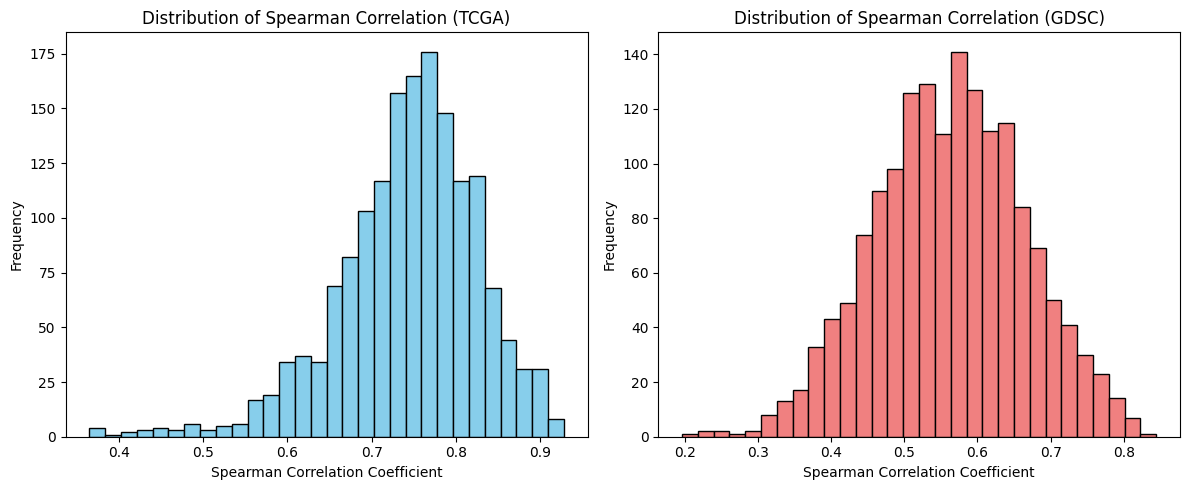

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Load predictions and targets
tcga_predictions = np.load("train_predictions.npy")
tcga_targets = np.load("train_targets.npy")
gdsc_predictions = np.load("test_predictions.npy")
gdsc_targets = np.load("test_targets.npy")

# Compute Spearman correlation for each gene
tcga_spearman = [spearmanr(tcga_targets[:, i], tcga_predictions[:, i])[0] for i in range(tcga_targets.shape[1])]
gdsc_spearman = [spearmanr(gdsc_targets[:, i], gdsc_predictions[:, i])[0] for i in range(gdsc_targets.shape[1])]

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(tcga_spearman, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Spearman Correlation (TCGA)')
plt.xlabel('Spearman Correlation Coefficient')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(gdsc_spearman, bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Spearman Correlation (GDSC)')
plt.xlabel('Spearman Correlation Coefficient')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
